# Étude du temps de sélection

Le but est de prédire la durée entre la demande d'intervention et le départ effectif d'un véhicule de sa caserne. C'est en effet le prmeier délivrable prédit, qui contribut à la durée total entre la demande d'intervention et la présentation effective des pompiers.

Nous allons donc analyser quels sont les paramètres qui influencent cette durée, en complexifiant au fur à mesure le modèle en prenant en compte plus de paramètres.

In [1]:
import pandas as pd
import scipy as sp
import os
import numpy as np
import pprint
import seaborn as sns
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from IPython.core.display import display, HTML

In [6]:
import sys

sys.path.insert(0, os.path.join(os.path.dirname(os.path.realpath(".")), "code"))


# Home-made helpers functions
from settings import TRAINING_DATA, TRAFFIC_DATA, DATA_FOLDER, INDEX_COLUMN

In [7]:
# make /comfy/ notebook 
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["figure.figsize"] = (30, 10)
sns.set(color_codes=True)

In [8]:
x_train = pd.read_csv(os.path.join(TRAINING_DATA, 'x_train.csv'), sep=',', index_col=INDEX_COLUMN)
y_train = pd.read_csv(os.path.join(TRAINING_DATA, 'y_train.csv'), sep=',', index_col=INDEX_COLUMN)

In [24]:
delta = np.array(y_train["delta selection-departure"])
t_mean = np.mean(delta)
print("Temps moyen : ", t_mean)
var = np.var(delta)
print("Dispersion : ", var)
print(delta.shape)

Temps moyen :  138.77180776613156
Dispersion :  6038.906229913341
(219337,)


On voit donc qu'on a un temps moyen très court, d'un peu plus de deux minutes, mais avec une très très grande variance. On separt artificiellement les données en deux groupes, plus ou moins de 4 minutes.

Text(0.5, 1.0, 'delta>400')

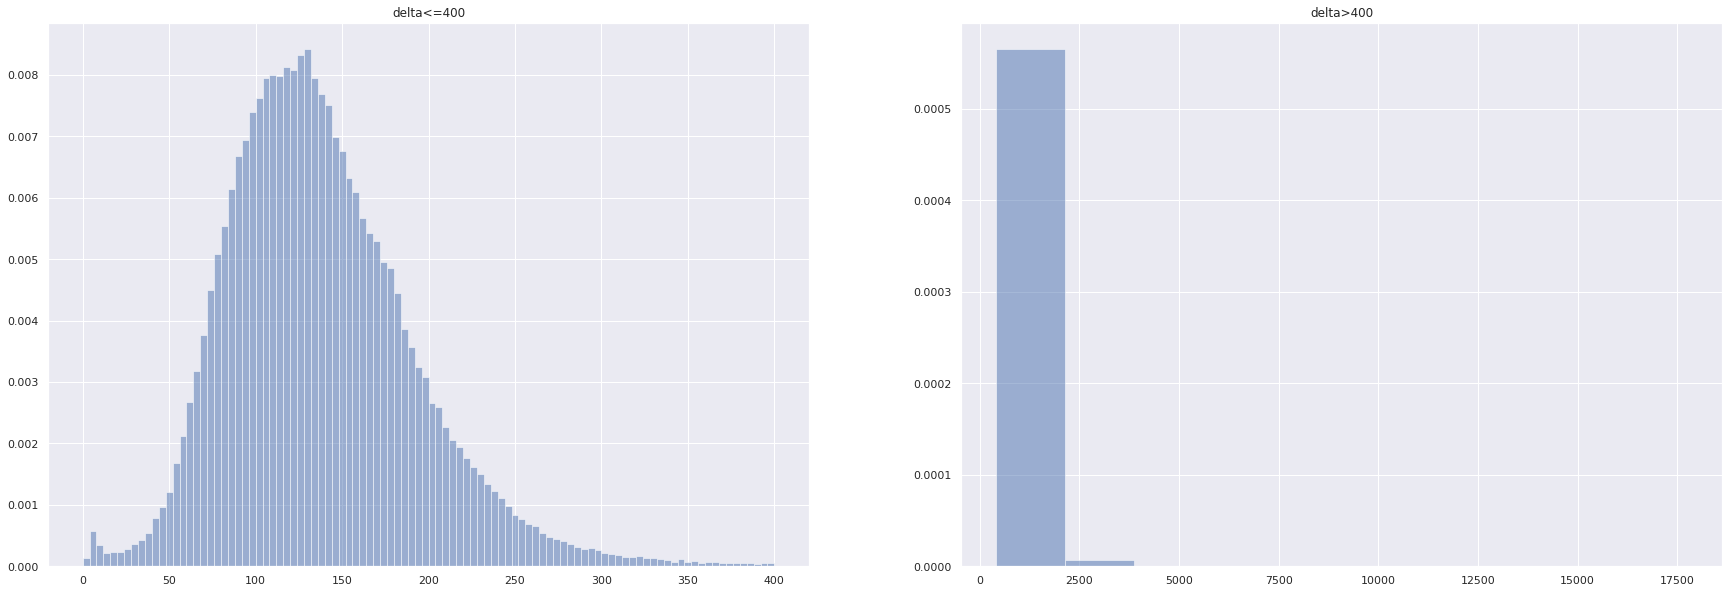

In [12]:
delta_court = delta[delta<=400]
delta_long = delta[delta> 400]

plt.subplot(1, 2, 1)
plt.hist(delta_court, bins=100, density=True, alpha=0.5);
plt.title('delta<=400')

plt.subplot(1, 2, 2)
plt.hist(delta_long, bins= 10, density=True, alpha=0.5);
plt.title('delta>400')

## Dépendance avec le type de véhicule

Le premier paramètre qui semble intuitivement influencé le départ est le type de véhicule utilisé, qui correspond au champ **emergency vehicle type**. En séparant les données selon ce critère, on obtient les données suivantes:

In [5]:
type_vehicule = np.array(x_train["emergency vehicle type"])
especes, nb_repr = np.unique(type_vehicule, return_index = True)
print(len(especes),especes)
print(nb_repr)

75 ['AR' 'BEAA BSPP' 'CA' 'CCR BSPP' 'CD BSPP' 'CESD' 'CFS' 'CMO APP' 'CRAC'
 'CRF' 'CSP' 'DAP' 'DEP' 'EPA BSPP' 'EPAN' 'EPSA' 'ESAV' 'ESAVI' 'FA'
 'FFSS' 'FMOGP BSPP' 'FNPC' 'FPT BSPP' 'FPT SSLIA' 'FPTL BSPP' 'OHFOM'
 'PEV' 'PSE' 'PST' 'SFCB' 'SP' 'SP BALLON' 'SPTT' 'UMH' 'UMH 75' 'UMH 92'
 'UMH 93' 'UMH 94' 'UMH BOBI' 'UMH DEBREPED' 'UMH DIEU' 'UMH GARC'
 'UMH LARIB' 'UMH MONDOR' 'UMH NECK' 'UMH NECKPED' 'UMH PITIE' 'UMH STDE'
 'UMPS' 'VAS' 'VE2I' 'VEC' 'VELD' 'VID' 'VIGI' 'VIMP' 'VIRB' 'VLHP'
 'VLR BSPP' 'VPB' 'VPC GFIS' 'VPC GIS' 'VPS' 'VRA' 'VRCH BSPP' 'VRCP'
 'VRM' 'VRSD' 'VSAV BALA' 'VSAV BSPP' 'VSAV SDIS' 'VSAV SSLIA' 'VSIS'
 'VSTI' 'VTBA']
[   182    164   5644     53    980   5064   3430  95521    671     48
 204976 156339   7591     40     32    914   1626  35188     63    280
   8354    146     47 179486    717   5094    963      1  59115   2790
   1118  42155  91030  13879   6442  35130   8566   9128  14991 175622
   3104  23397  17393  30844   3433  27608  40370 216921   

In [18]:
def histo(col):
    counts = dict(col.value_counts().sort_index())
    indices = list(counts.keys())
    values = list(counts.values())
    chart = sns.barplot(x=indices, y=values)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90) ; 
    chart.set_title(f"{col.name} occurences") ; 

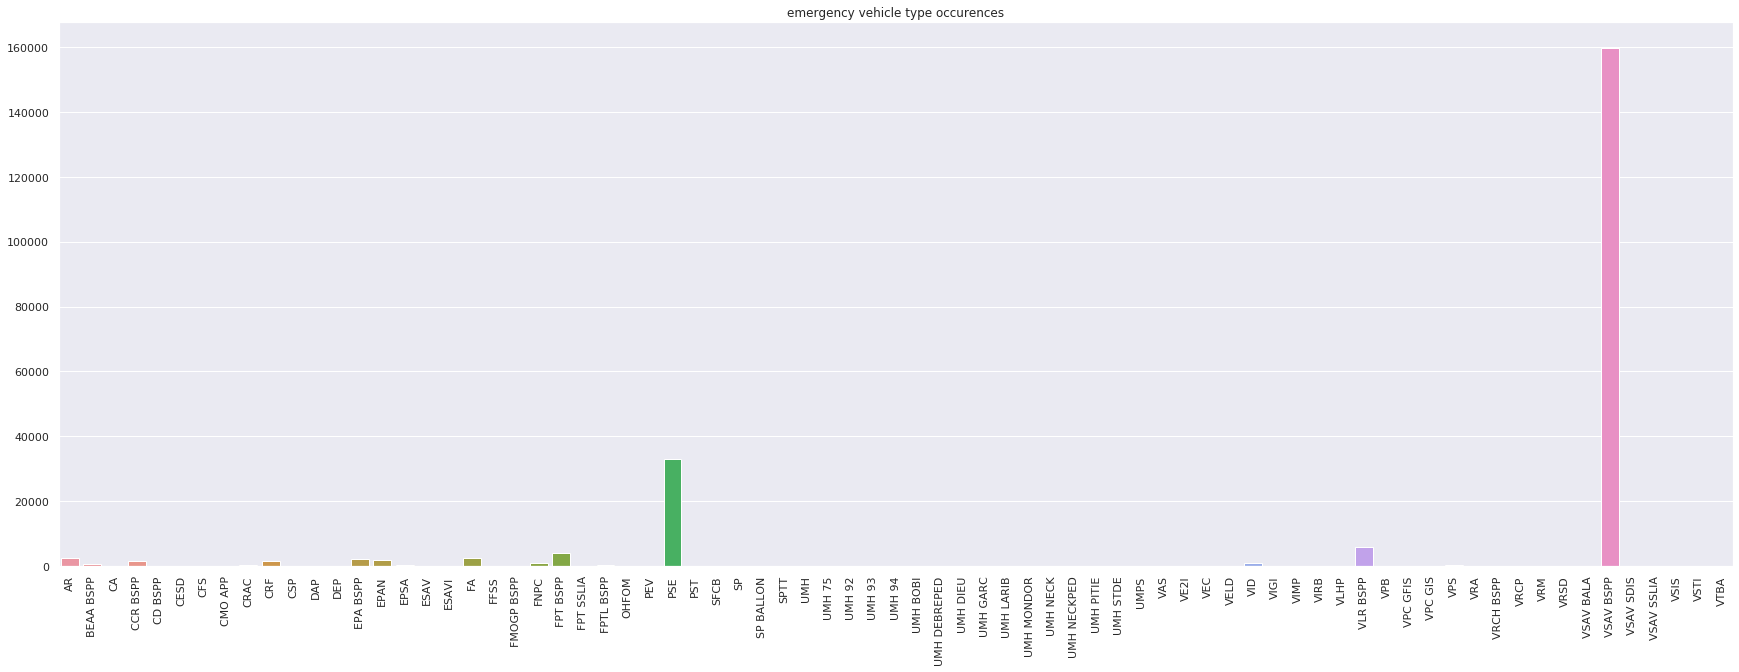

In [20]:
histo(x_train["emergency vehicle type"])

Pas de distinction triviale donc, surtout que les acronymes ne sont pas vraiment explicite, même en regardant https://fr.wiktionary.org/wiki/Annexe:Abr%C3%A9viations_des_pompiers_de_France

In [6]:
data = x_train.merge(y_train, how="left", on="emergency vehicle selection")


for vehicule in especes :
    sous_base = data.loc[data["emergency vehicle type"] == vehicule]
    delta_spec = np.array(sous_base["delta selection-departure"])
    print("pour le type ", vehicule)
    print("      ", np.mean(delta_spec))
    print("      ", np.var(delta_spec))
    print("      ", len(delta_spec))


pour le type  AR
       218.34030197444832
       23678.73088446166
       2583
pour le type  BEAA BSPP
       161.38977072310405
       3451.9521352208008
       567
pour le type  CA
       141.5
       12758.392857142857
       14
pour le type  CCR BSPP
       160.19467787114846
       28062.284229378016
       1428
pour le type  CD BSPP
       144.39506172839506
       6429.69577808261
       81
pour le type  CESD
       206.4
       18550.4
       25
pour le type  CFS
       95.875
       3120.359375
       8
pour le type  CMO APP
       165.25
       7213.1875
       4
pour le type  CRAC
       136.58157894736843
       4372.822292243768
       380
pour le type  CRF
       112.1059649122807
       1569.157192489997
       1425
pour le type  CSP
       188.0
       0.0
       1
pour le type  DAP
       88.0
       0.0
       1
pour le type  DEP
       488.53846153846155
       133274.09467455623
       26
pour le type  EPA BSPP
       150.6275559883155
       2980.4304188564074
   

In [22]:
x_train.keys()

Index(['emergency vehicle selection', 'intervention', 'alert reason category',
       'alert reason', 'intervention on public roads', 'floor',
       'location of the event', 'longitude intervention',
       'latitude intervention', 'emergency vehicle', 'emergency vehicle type',
       'rescue center', 'selection time', 'date key sélection',
       'time key sélection', 'status preceding selection',
       'delta status preceding selection-selection',
       'departed from its rescue center', 'longitude before departure',
       'latitude before departure',
       'delta position gps previous departure-departure',
       'GPS tracks departure-presentation',
       'GPS tracks datetime departure-presentation', 'OSRM response',
       'OSRM estimated distance', 'OSRM estimated duration'],
      dtype='object')

In [109]:
def boxplot(dataset, target_col, by_col, upper_clip, save_path=None):
    plt.figure()
    chart = dataset.boxplot(column=[target_col], by=by_col)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90) ; 
    chart.set_ylabel("(in seconds)")
    chart.set_title(chart.get_title() + f" (cropped at {upper_clip} sec.)")
    plt.ylim((0, upper_clip))
    if save_path is not None:
        plt.savefig(os.path.join(save_path, f"{target_col}_by_{by_col}".replace(" ","_")))
    plt.show()

def add_time_representation(X):
    """
    Add a time representation for the datetime

    :param X: data frame containing a Datetime series named `selection` time
    :return:
    """

    X["selection time"] = pd.to_datetime(X["selection time"])
    dt = X["selection time"].dt

    X["year"] = dt.year
    X["week_of_year"] = dt.weekofyear
    X["month"] = dt.month
    X["day"] = dt.day
    X["day_of_week"] = dt.dayofweek
    X["hour"] = dt.hour
    X["minute"] = dt.minute
    X["second"] = dt.second
    return X

joined = add_time_representation(x_train.join(y_train))
        
categ_vars = [
    'alert reason category',
    'alert reason',
    'intervention on public roads',
    'emergency vehicle type',
    'floor',
    'location of the event',
    'rescue center',
    'status preceding selection',
    'departed from its rescue center',
]

time_vars = ['week_of_year', 'month', 'day_of_week', 'day', 'hour', "minute"]

## Boite à moustaches sur le temps de préparation (`delta selection-departure`)

In [93]:
joined = add_time_representation(joined)

In [88]:
! mkdir -p ../report/figs/boxplots

<Figure size 2160x720 with 0 Axes>

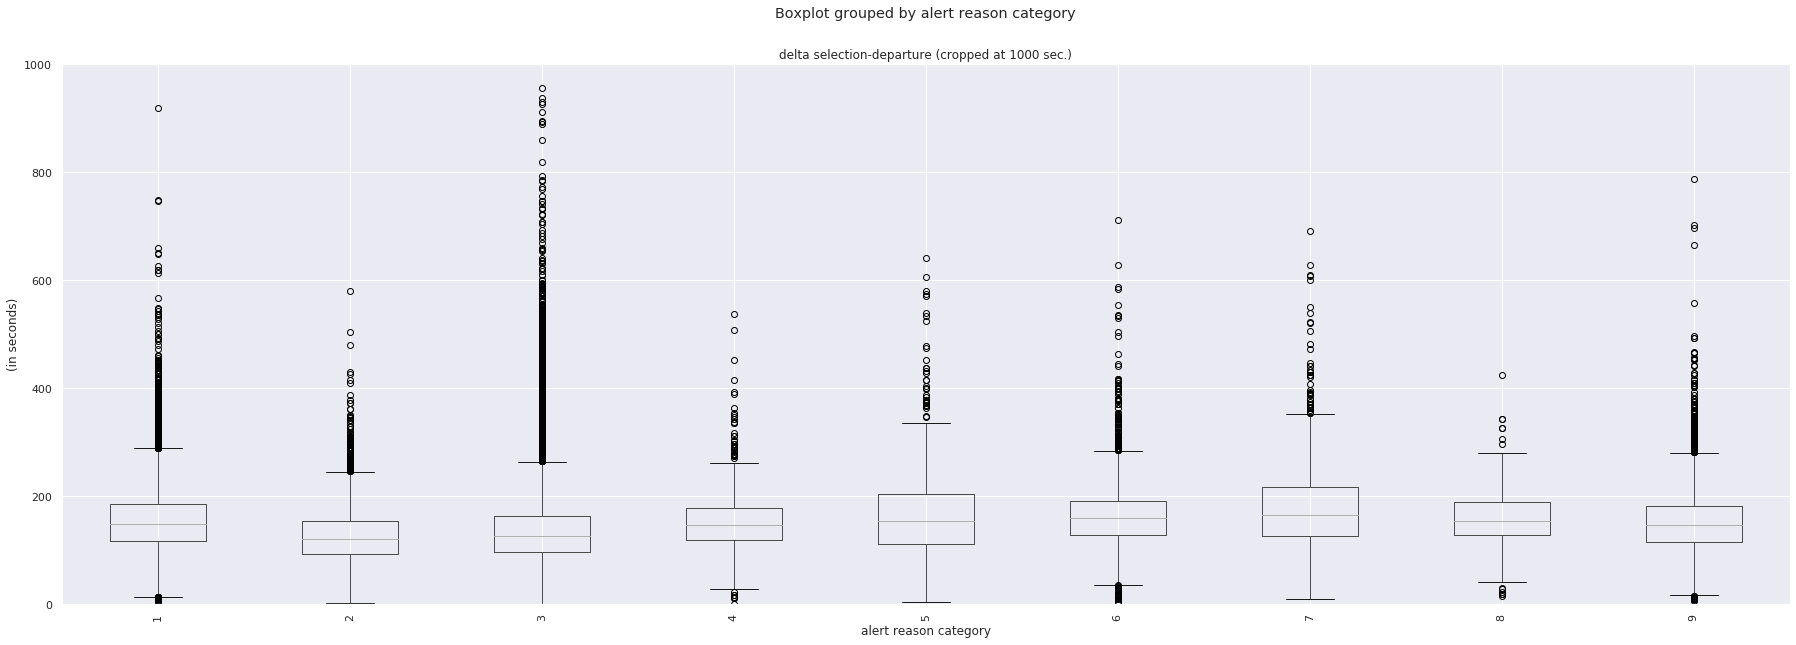

<Figure size 2160x720 with 0 Axes>

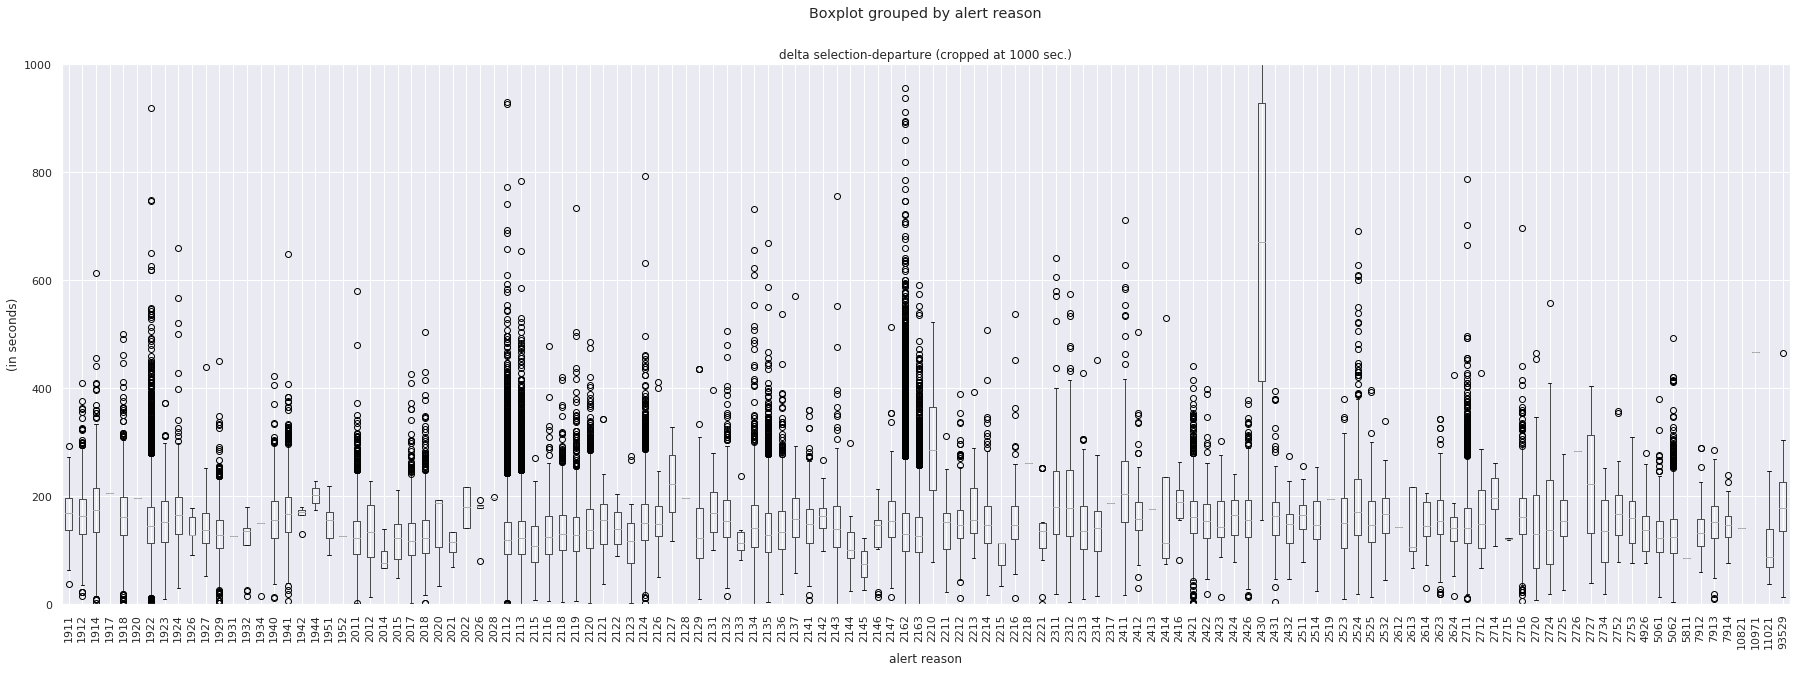

<Figure size 2160x720 with 0 Axes>

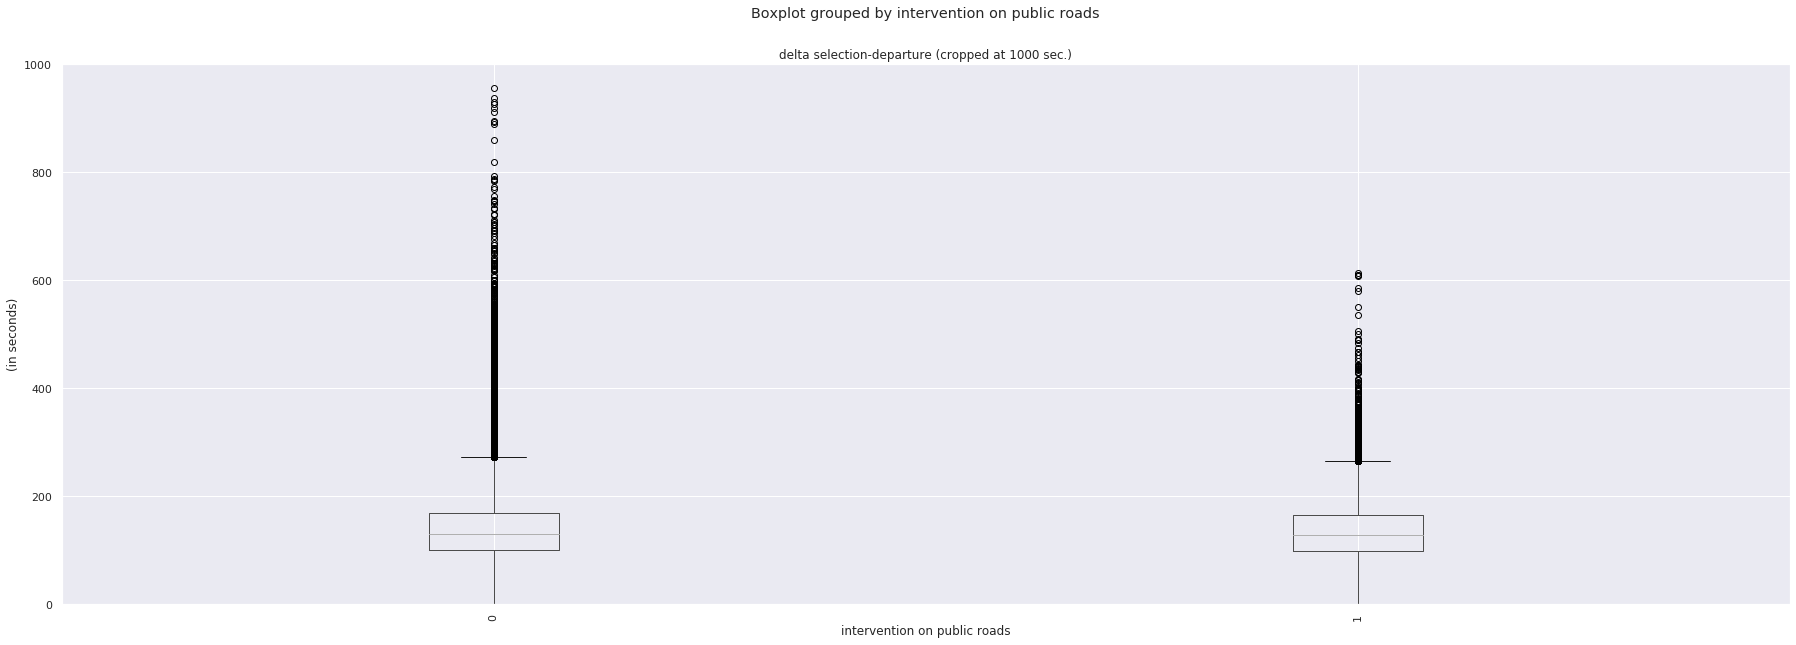

<Figure size 2160x720 with 0 Axes>

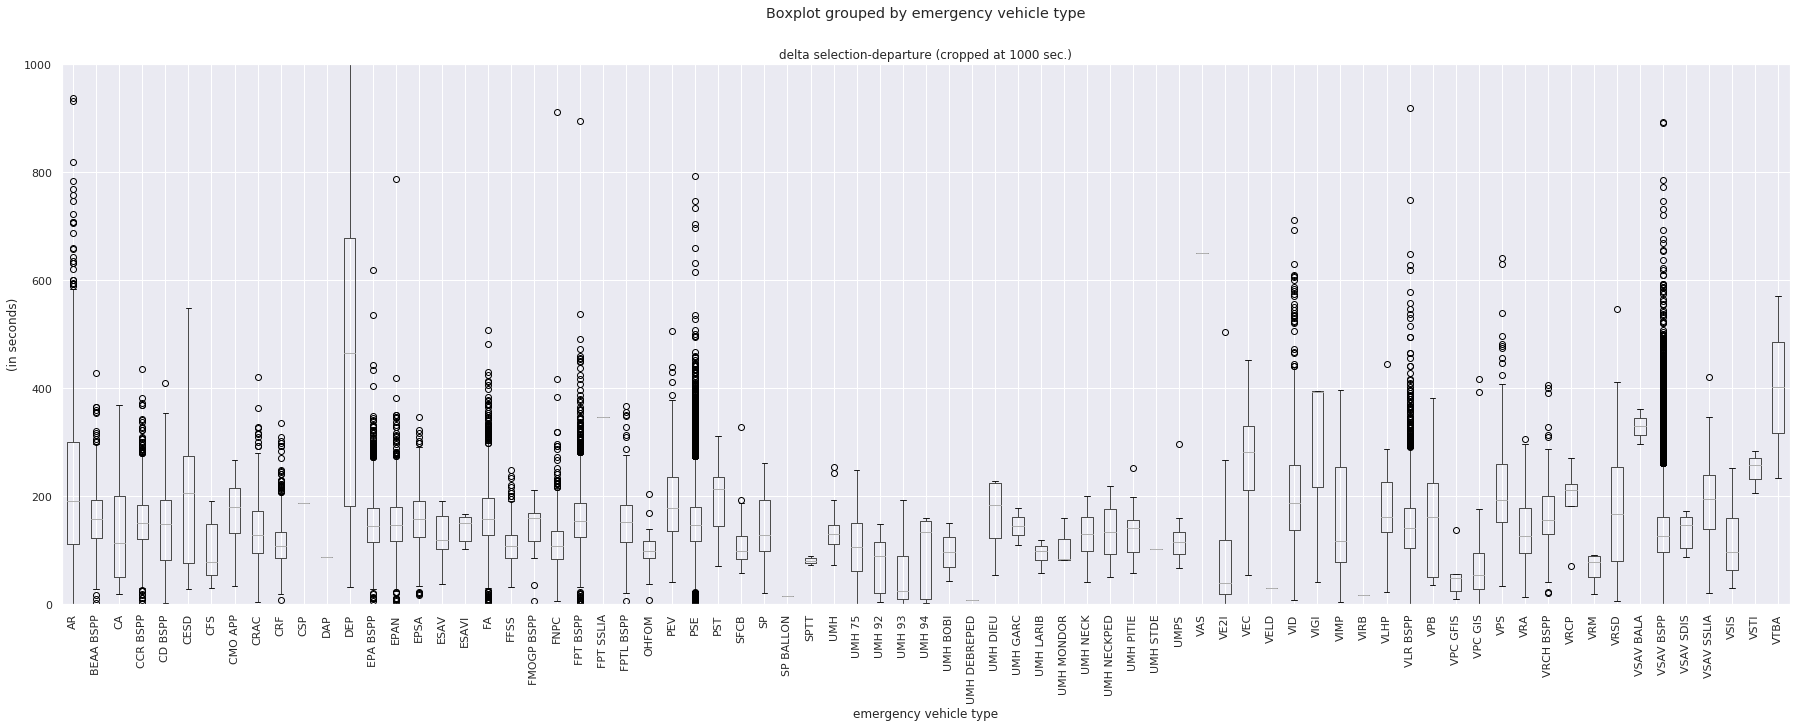

<Figure size 2160x720 with 0 Axes>

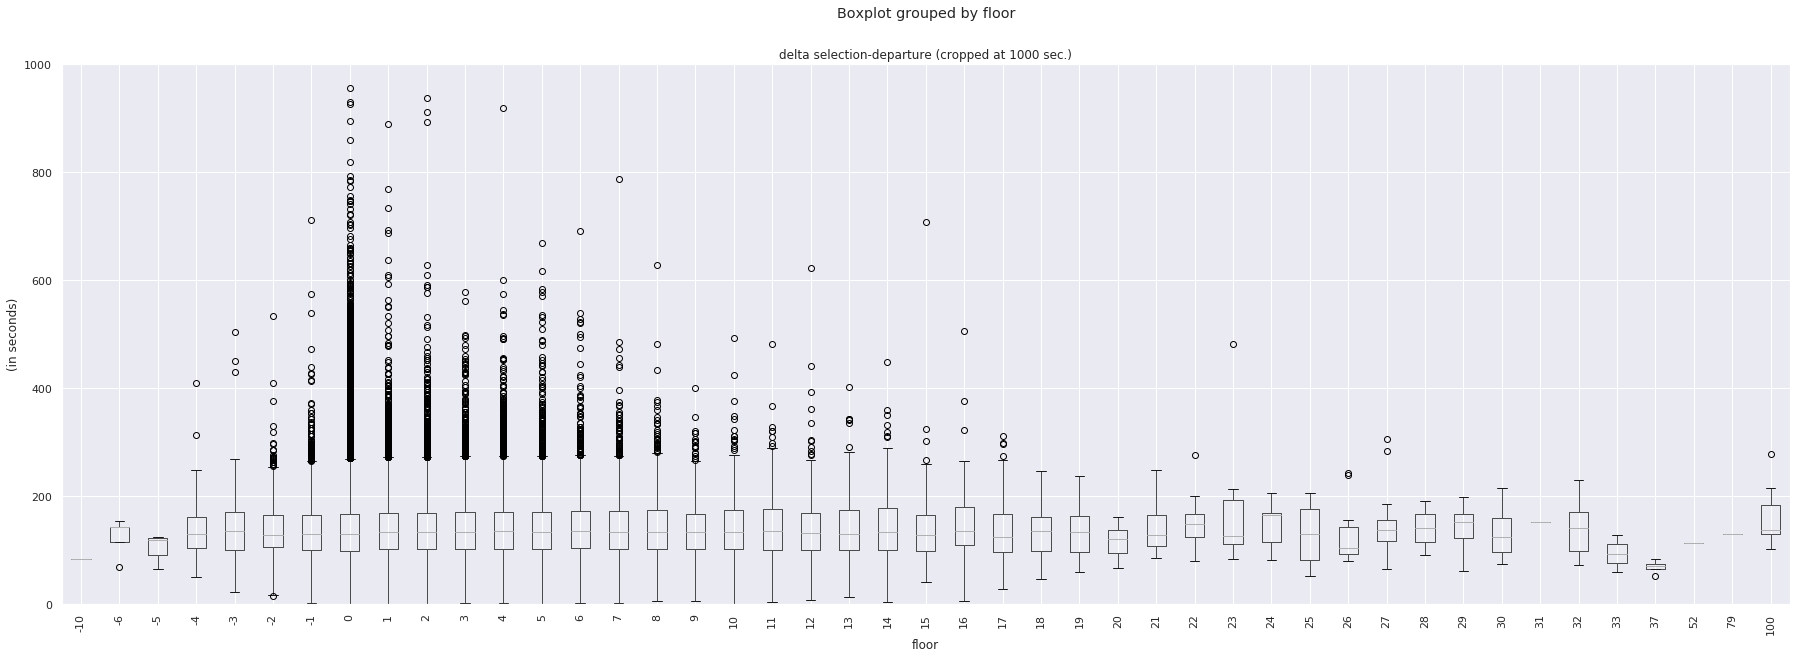

<Figure size 2160x720 with 0 Axes>

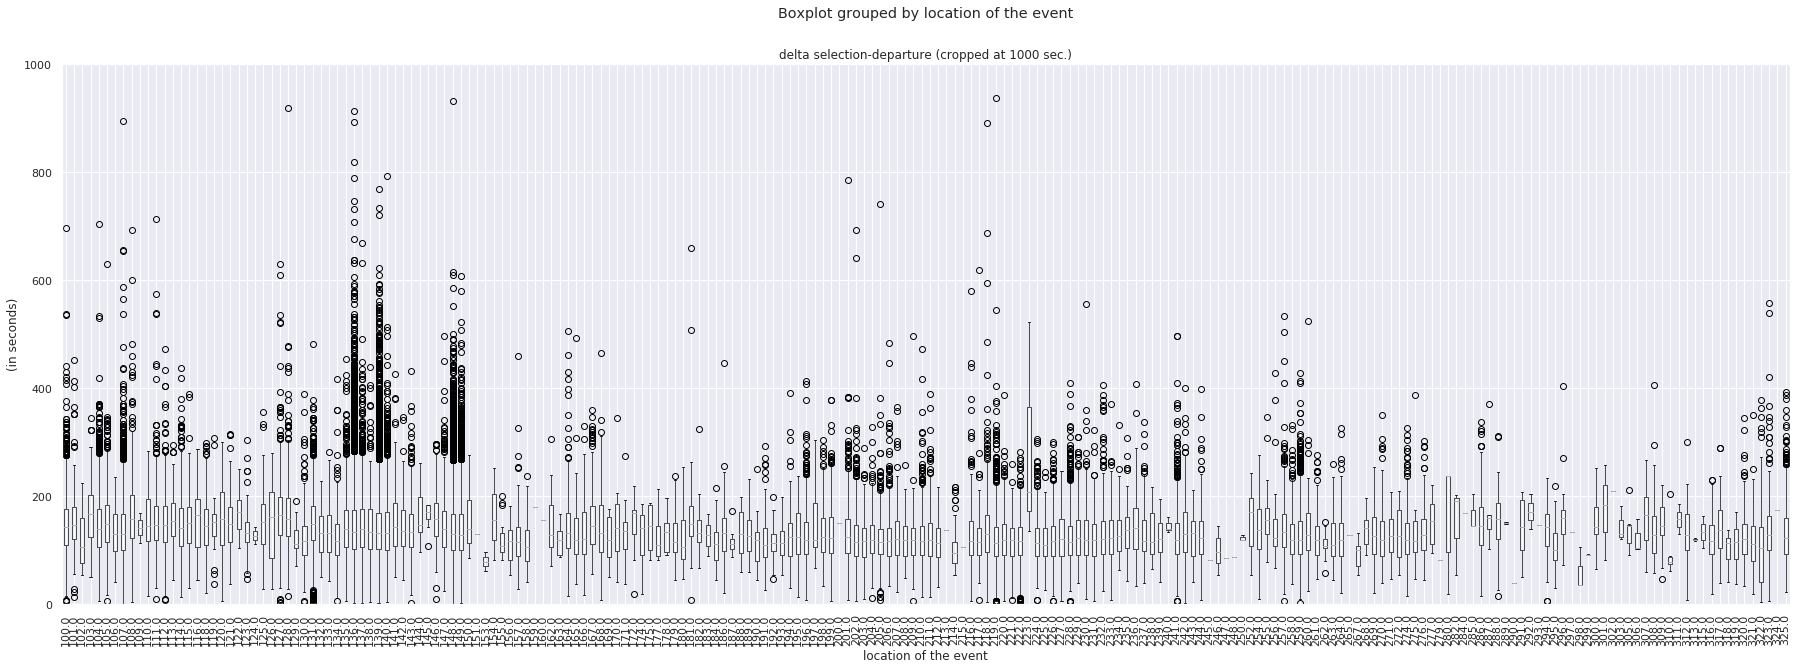

<Figure size 2160x720 with 0 Axes>

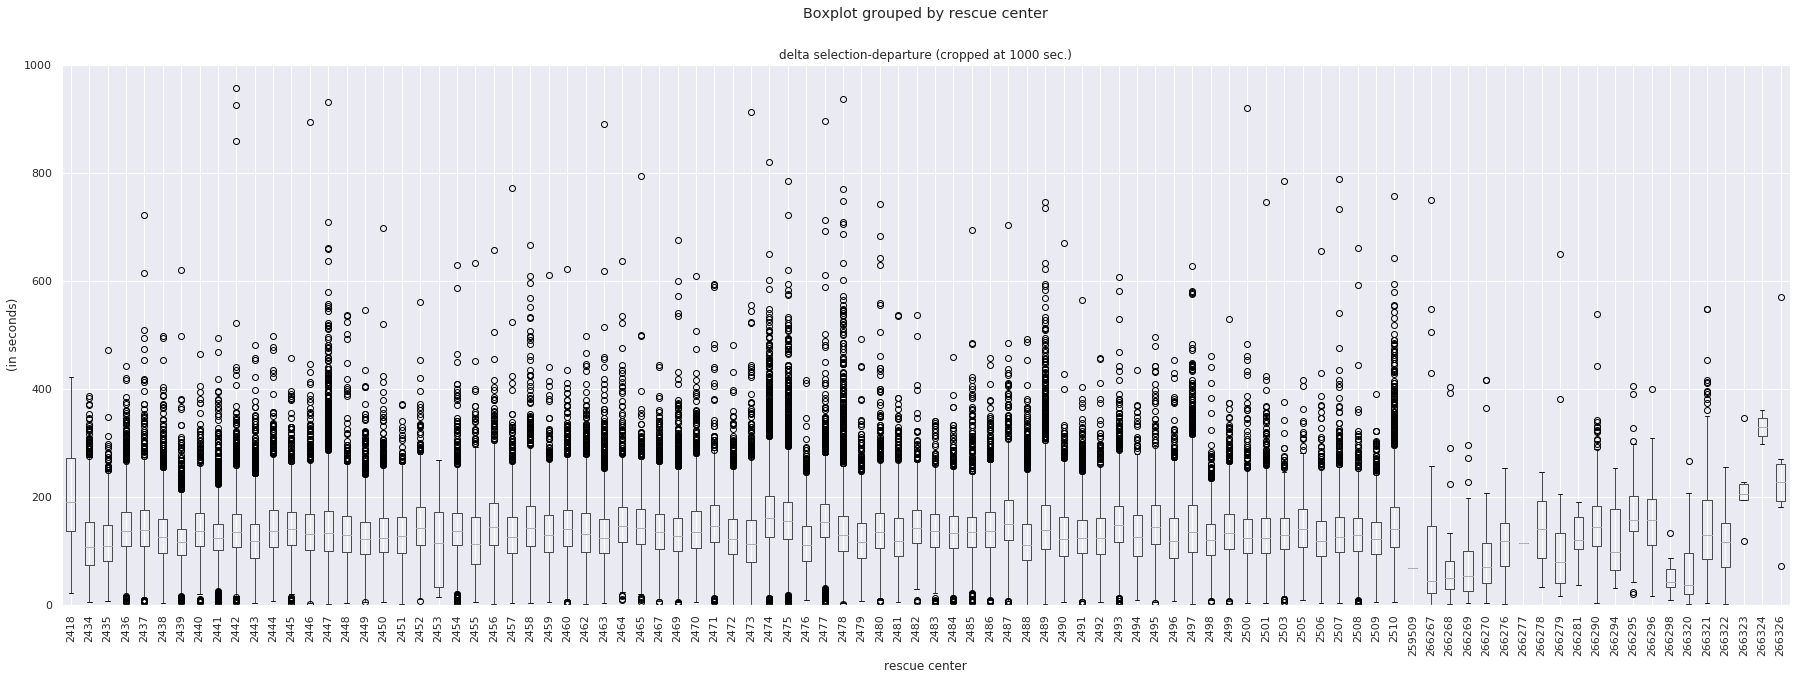

<Figure size 2160x720 with 0 Axes>

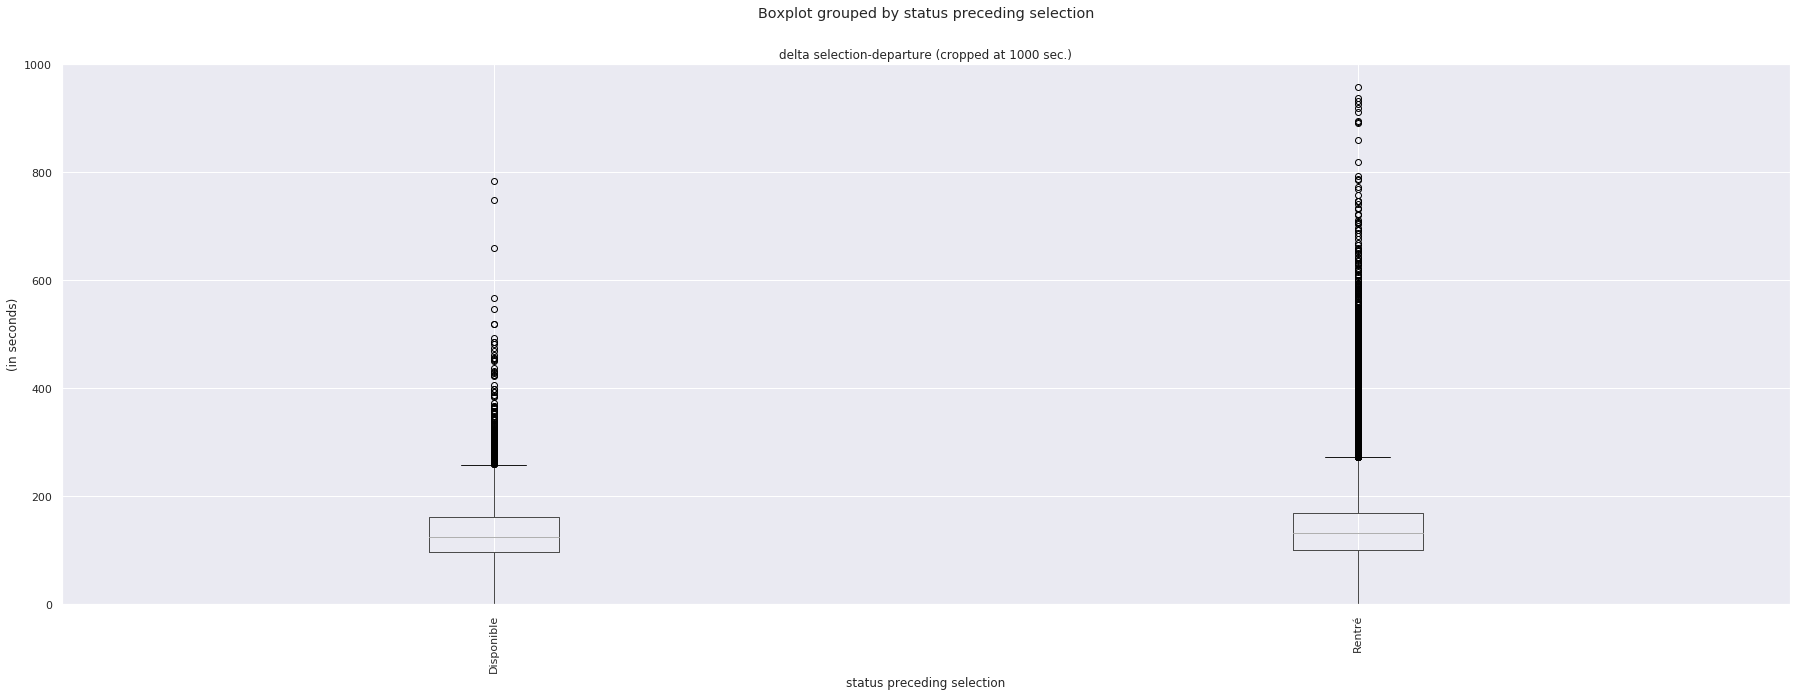

<Figure size 2160x720 with 0 Axes>

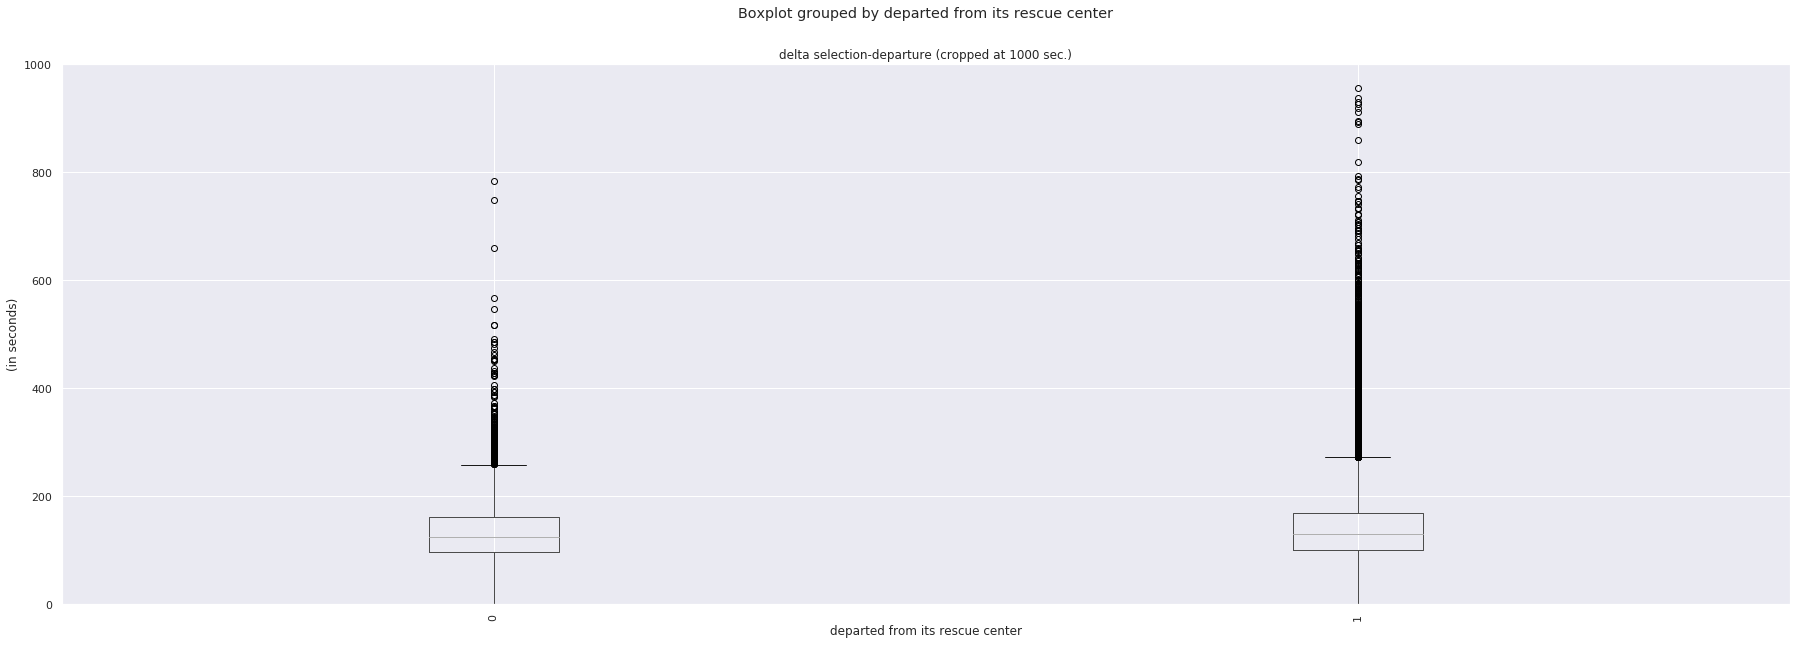

In [91]:
for var in categ_vars:
    boxplot(joined, "delta selection-departure", var, upper_clip=1000, save_path="../report/figs/boxplots/")

<Figure size 2160x720 with 0 Axes>

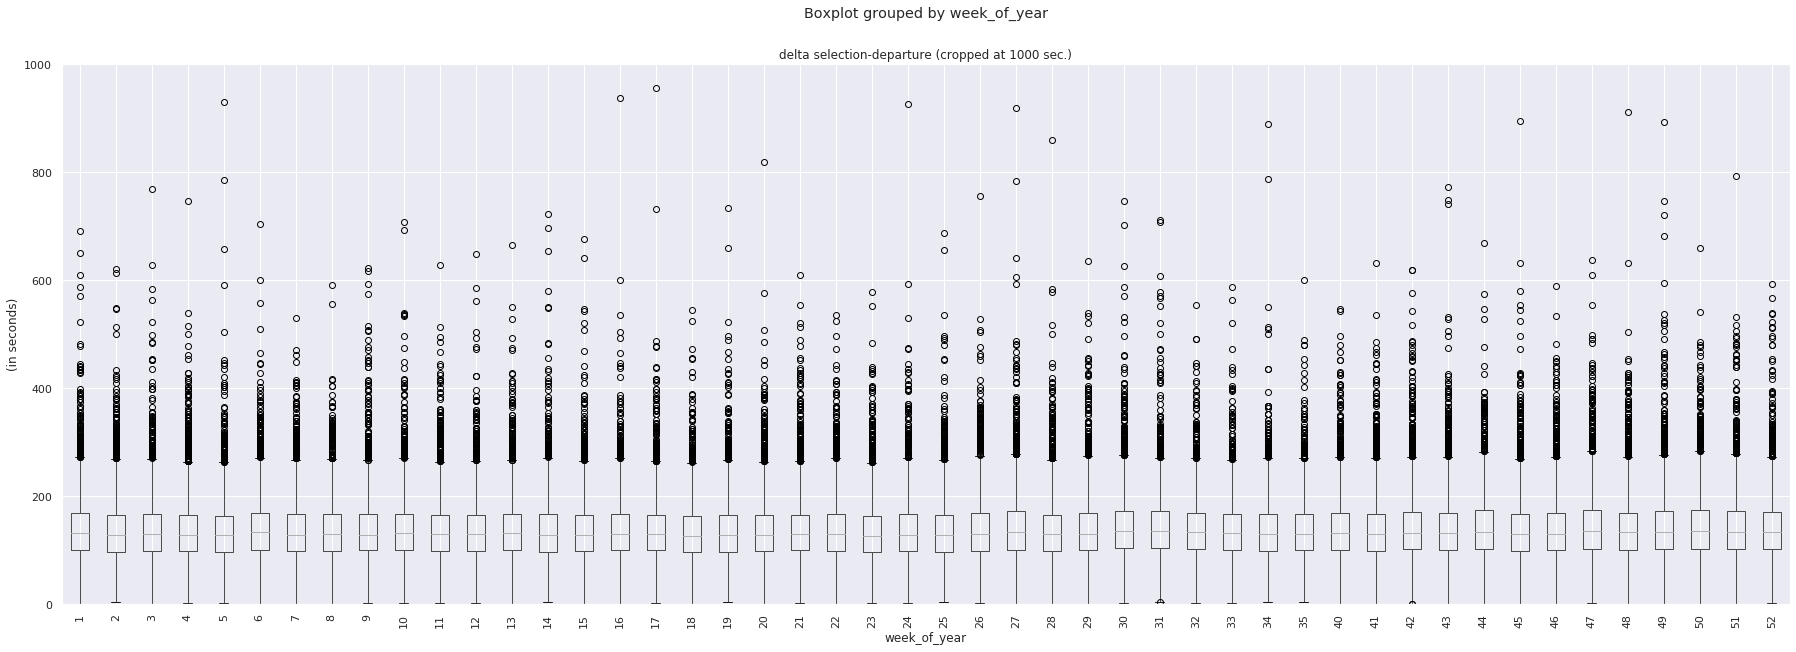

<Figure size 2160x720 with 0 Axes>

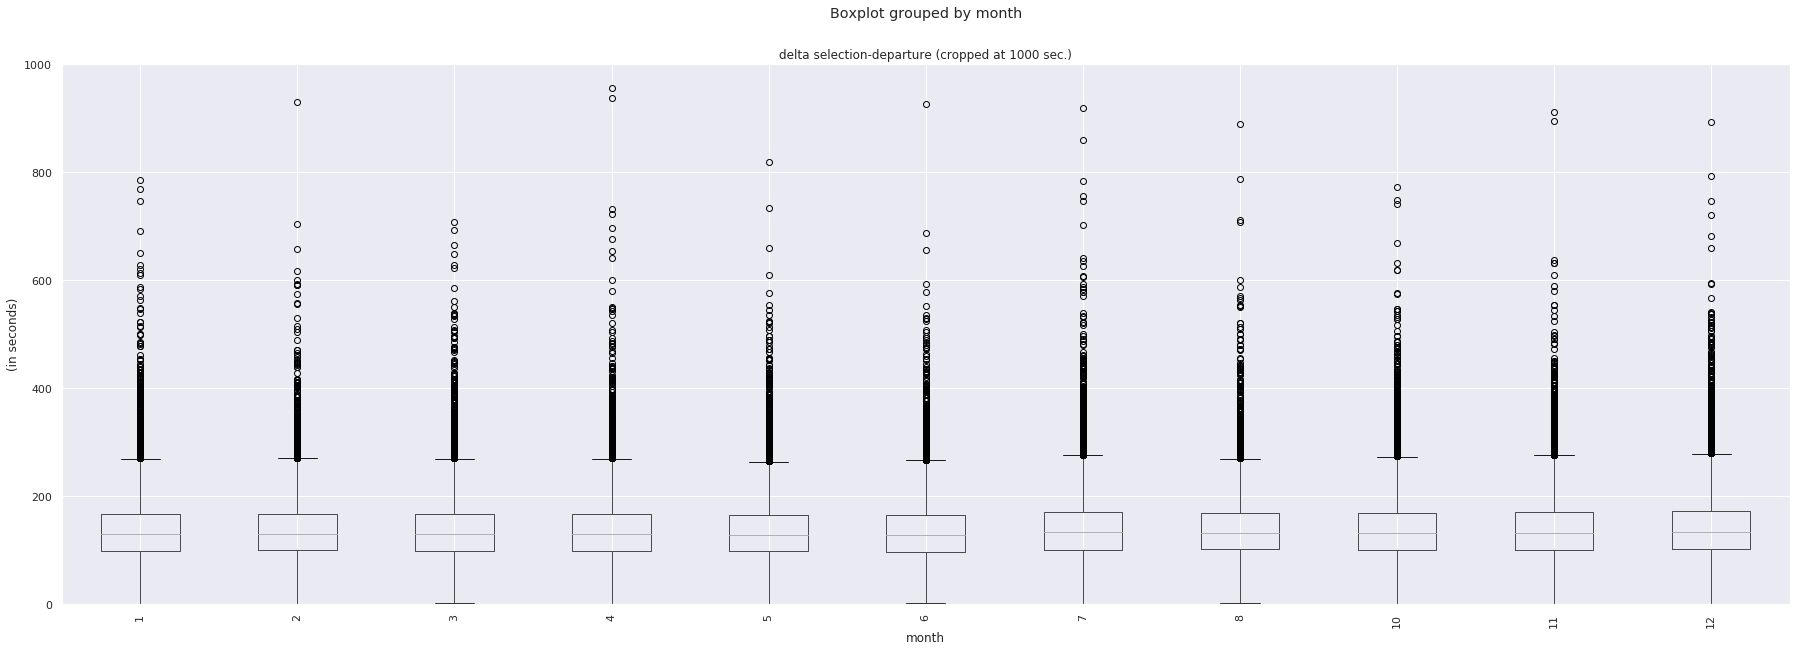

<Figure size 2160x720 with 0 Axes>

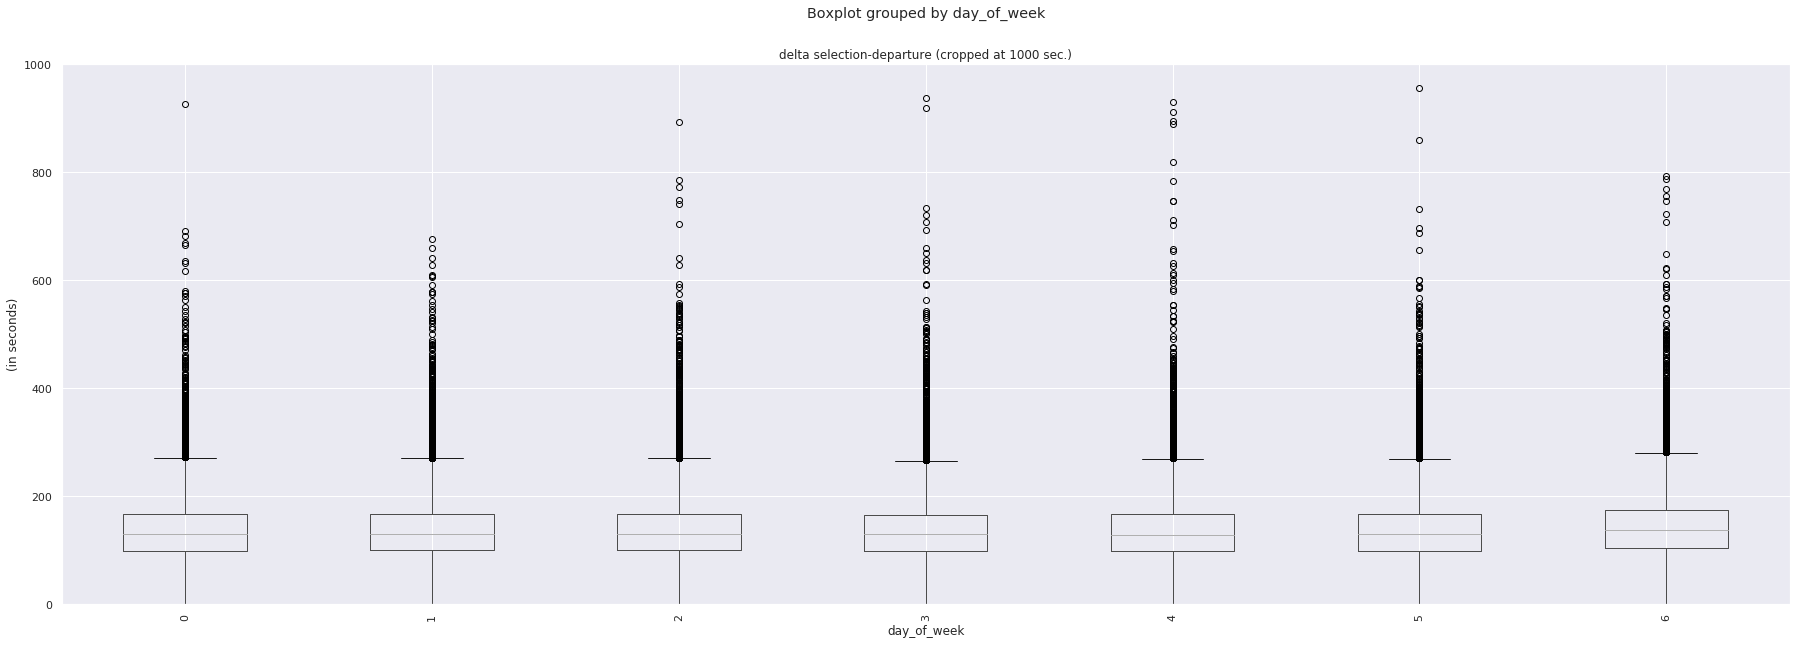

<Figure size 2160x720 with 0 Axes>

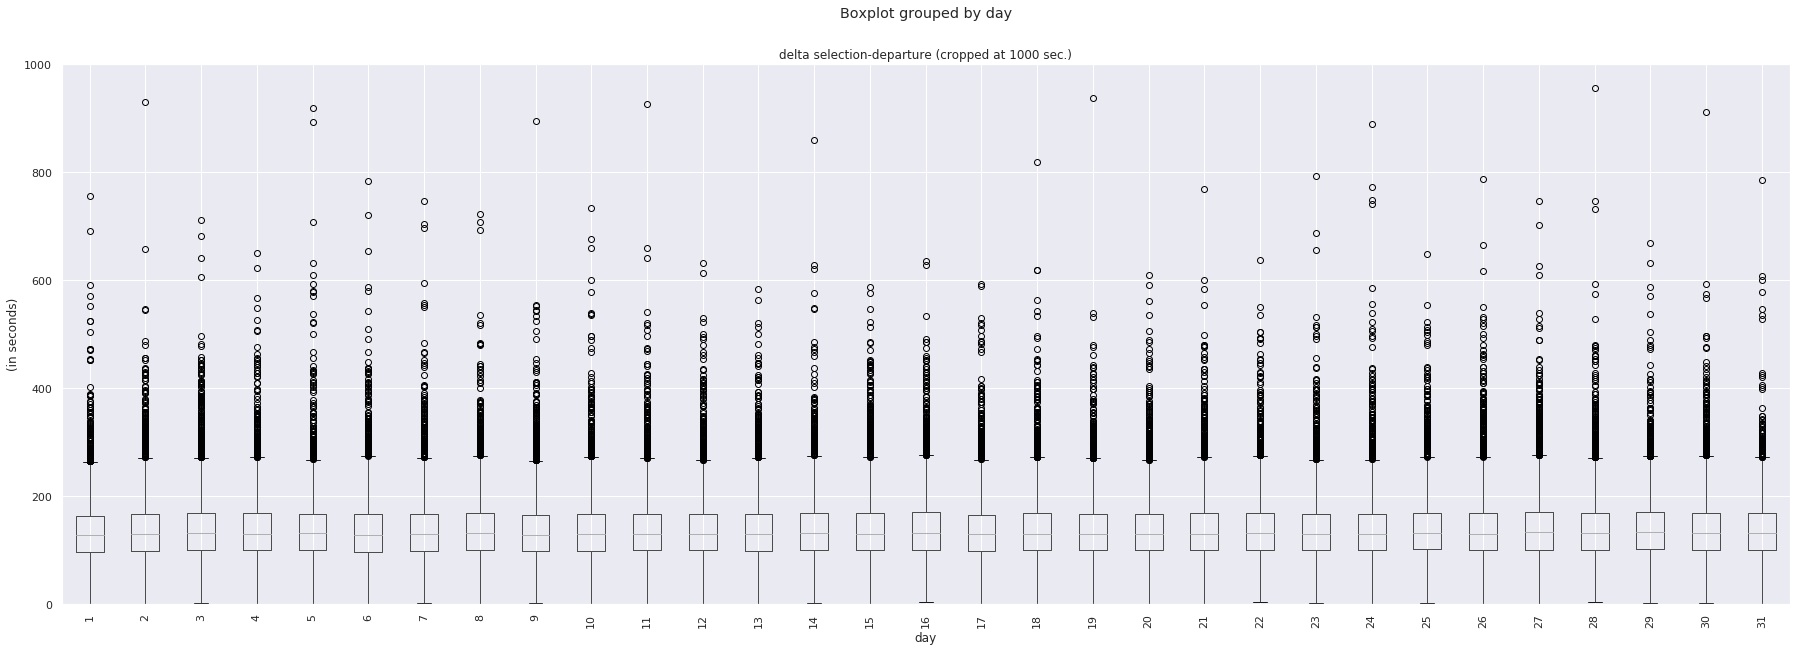

<Figure size 2160x720 with 0 Axes>

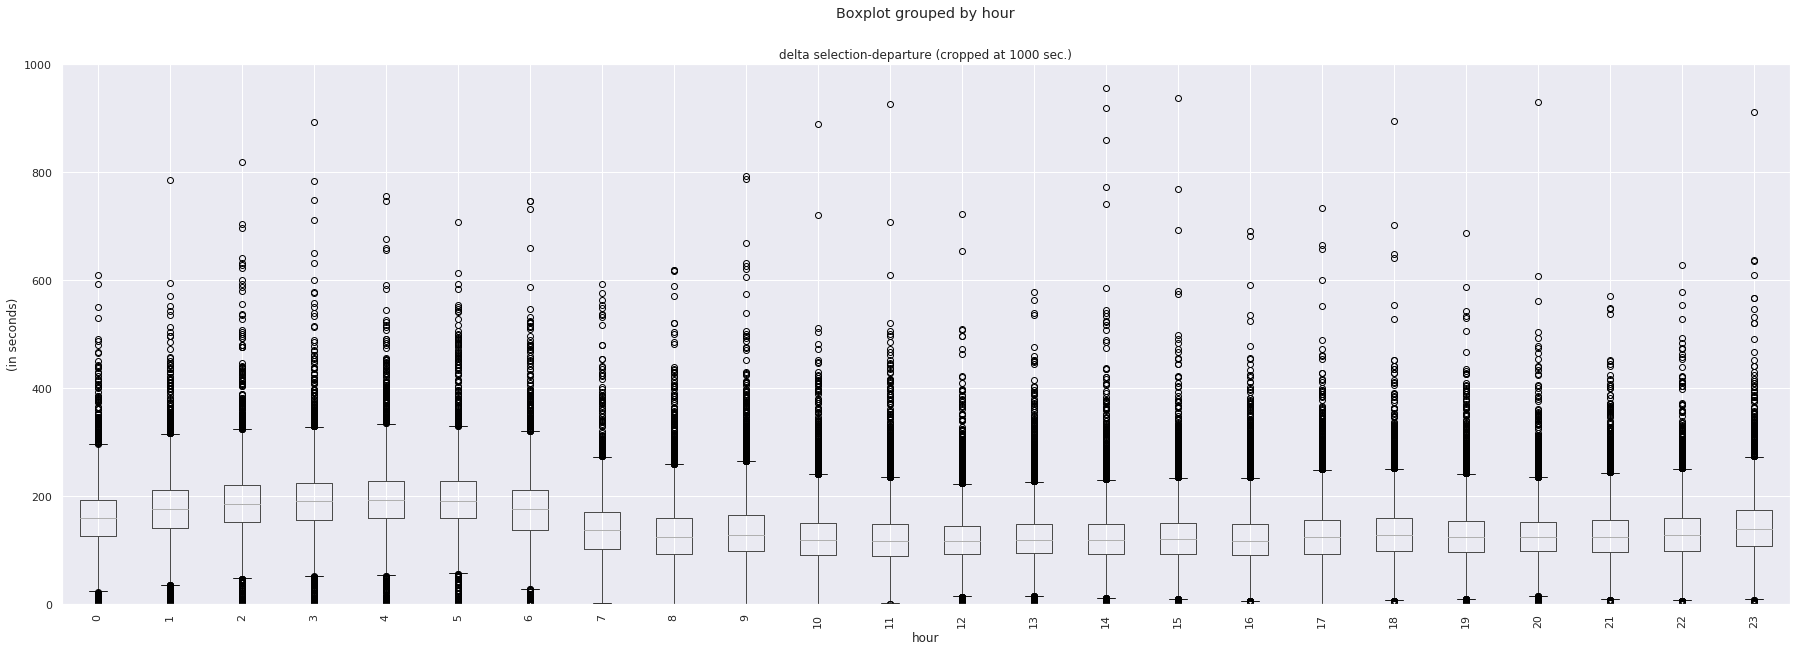

<Figure size 2160x720 with 0 Axes>

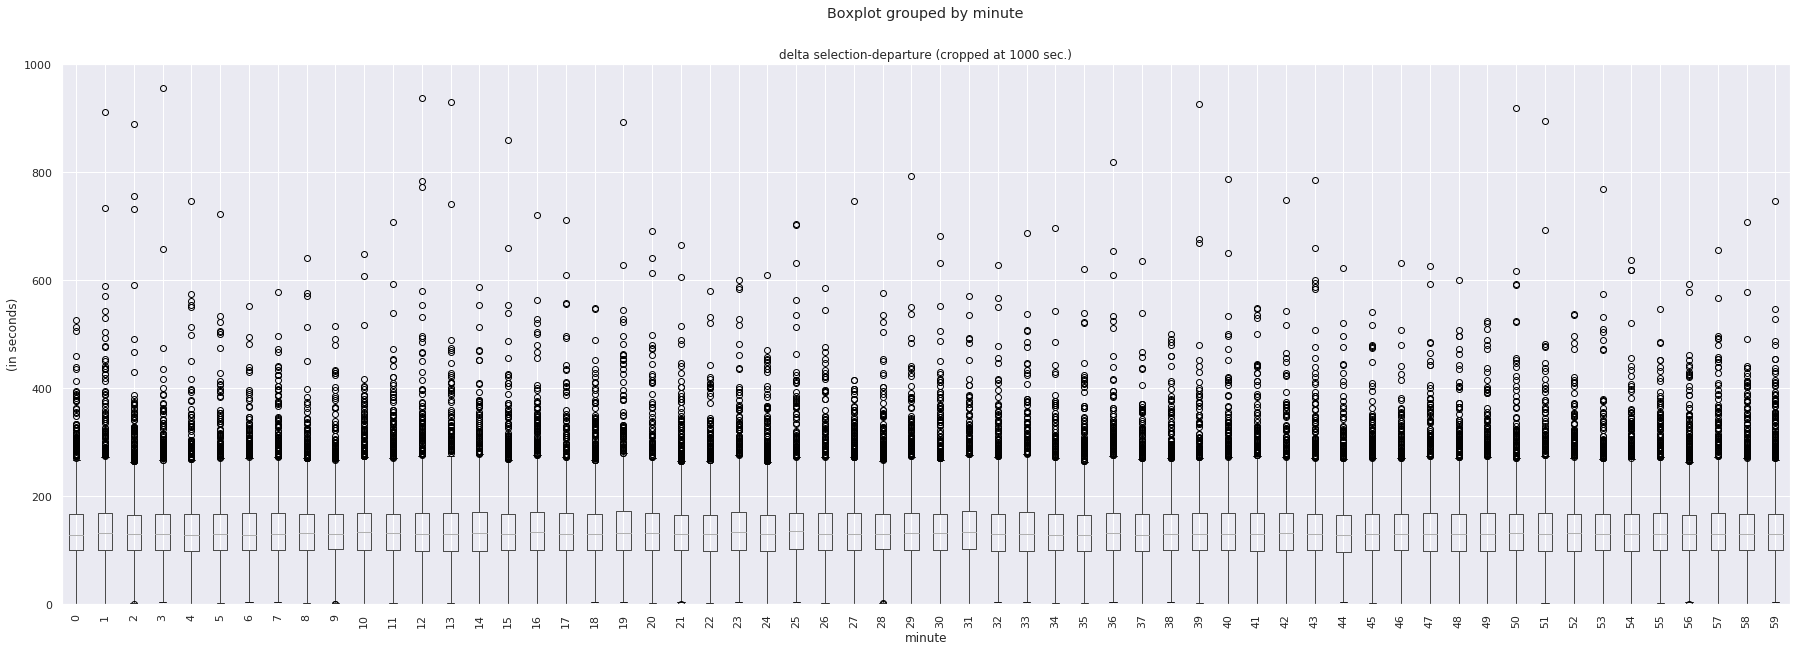

In [110]:
for var in time_vars:
    boxplot(joined, "delta selection-departure", var, upper_clip=1000, save_path="../report/figs/boxplots/time")

## Boite à moustaches sur le temps de transit (`delta departure-presentation`)

<Figure size 2160x720 with 0 Axes>

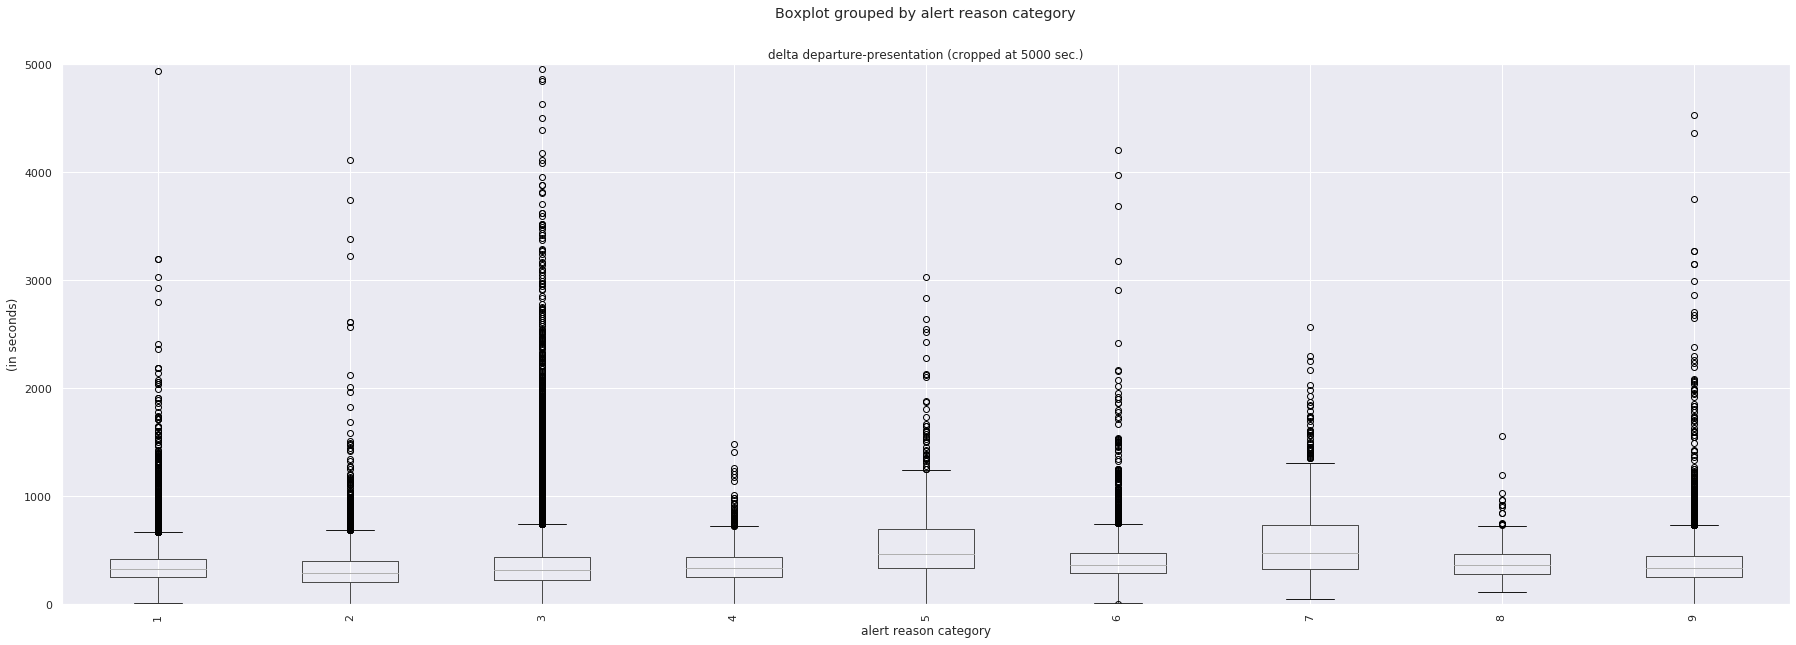

<Figure size 2160x720 with 0 Axes>

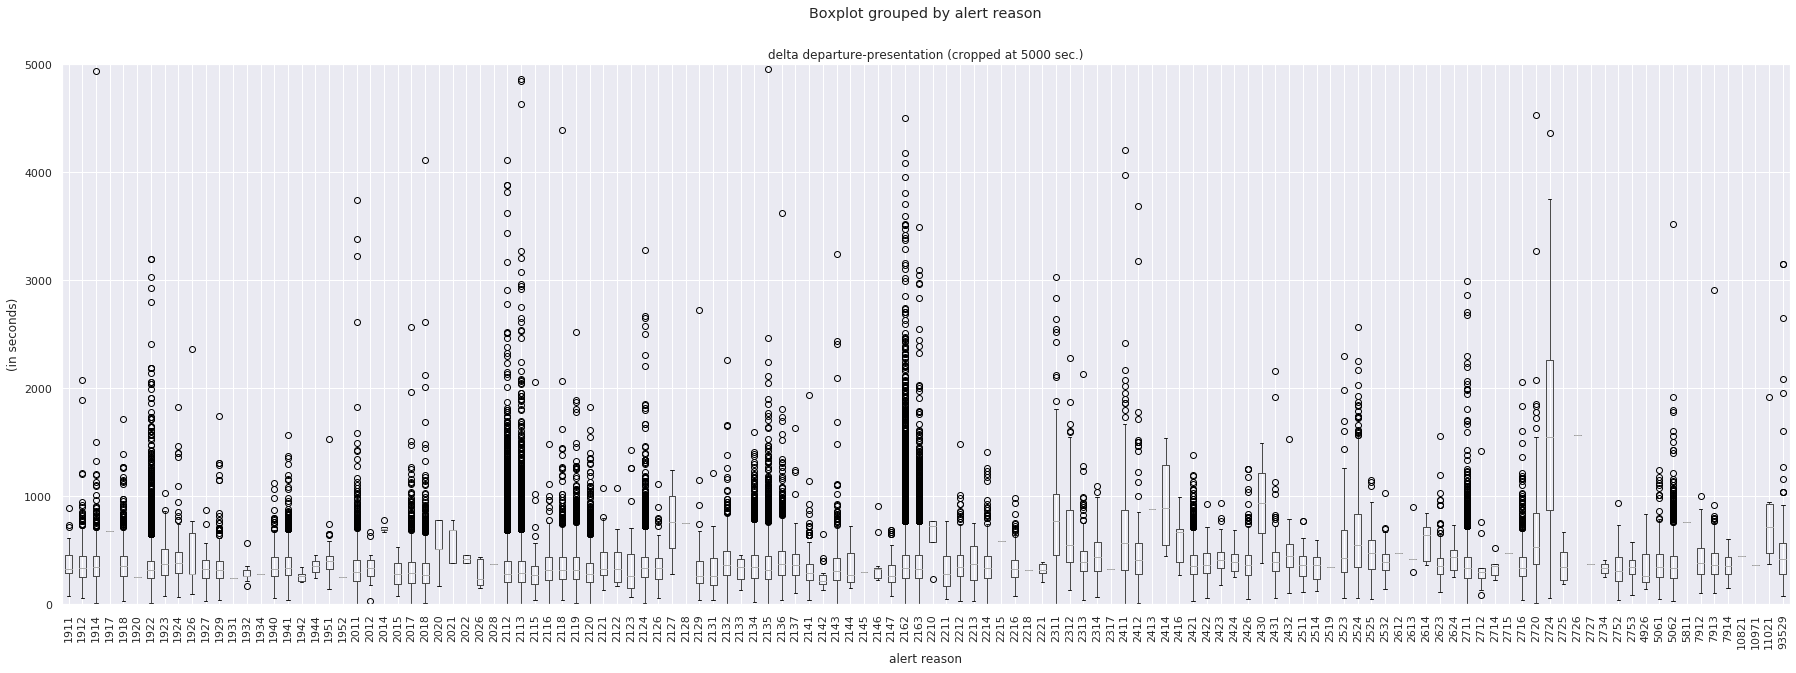

<Figure size 2160x720 with 0 Axes>

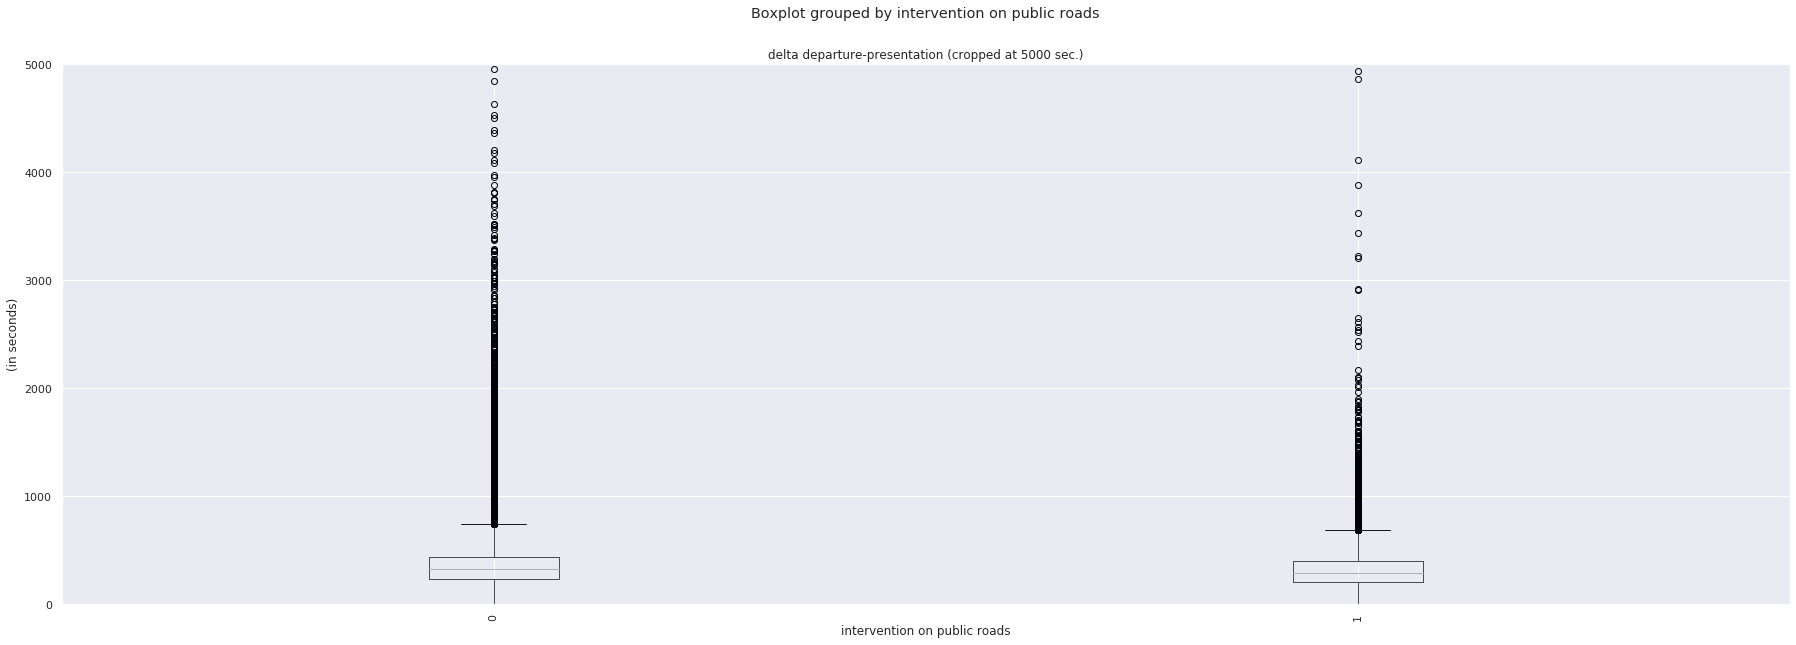

<Figure size 2160x720 with 0 Axes>

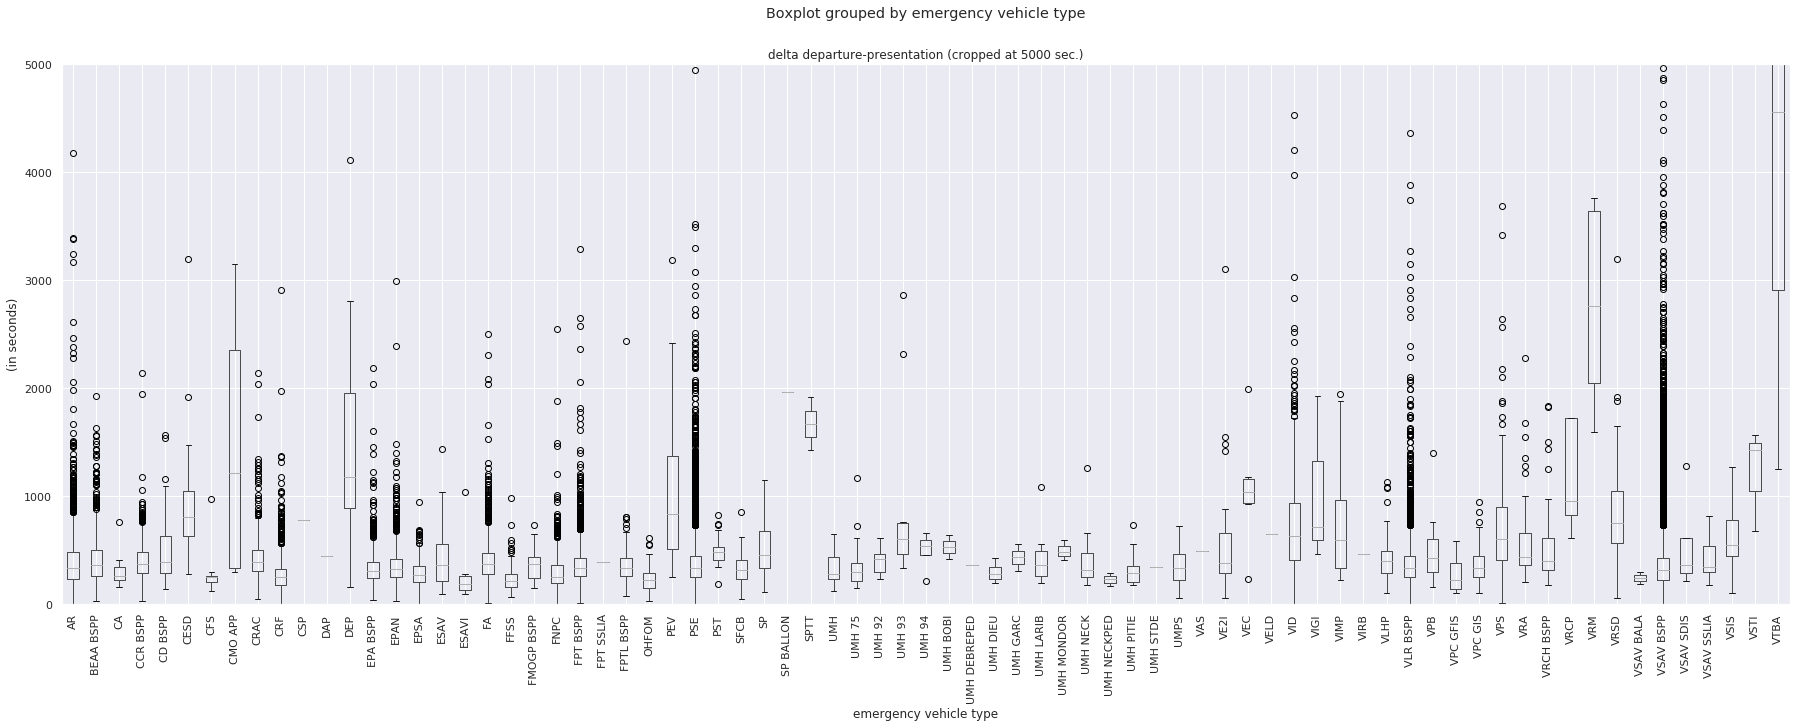

<Figure size 2160x720 with 0 Axes>

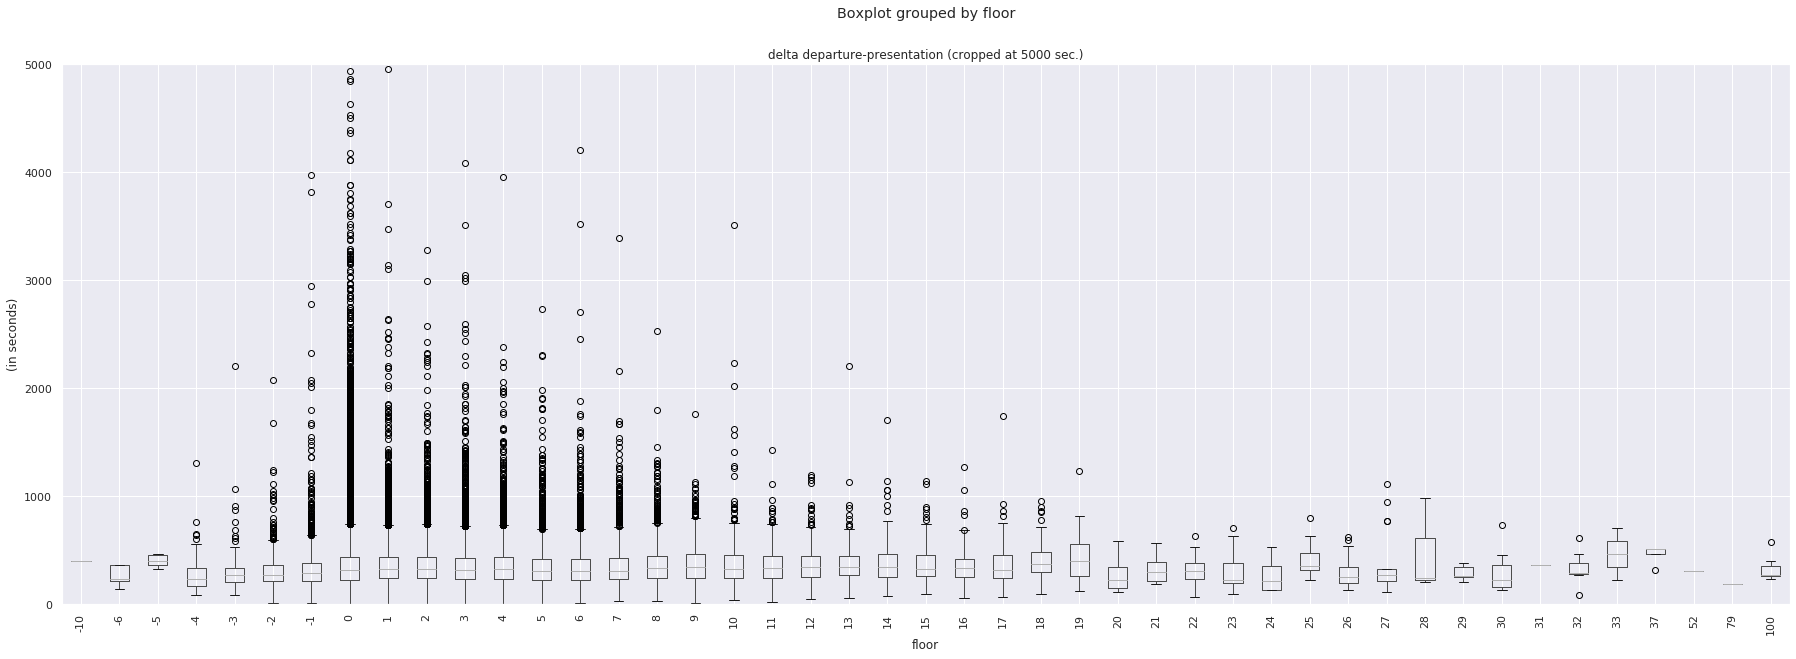

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

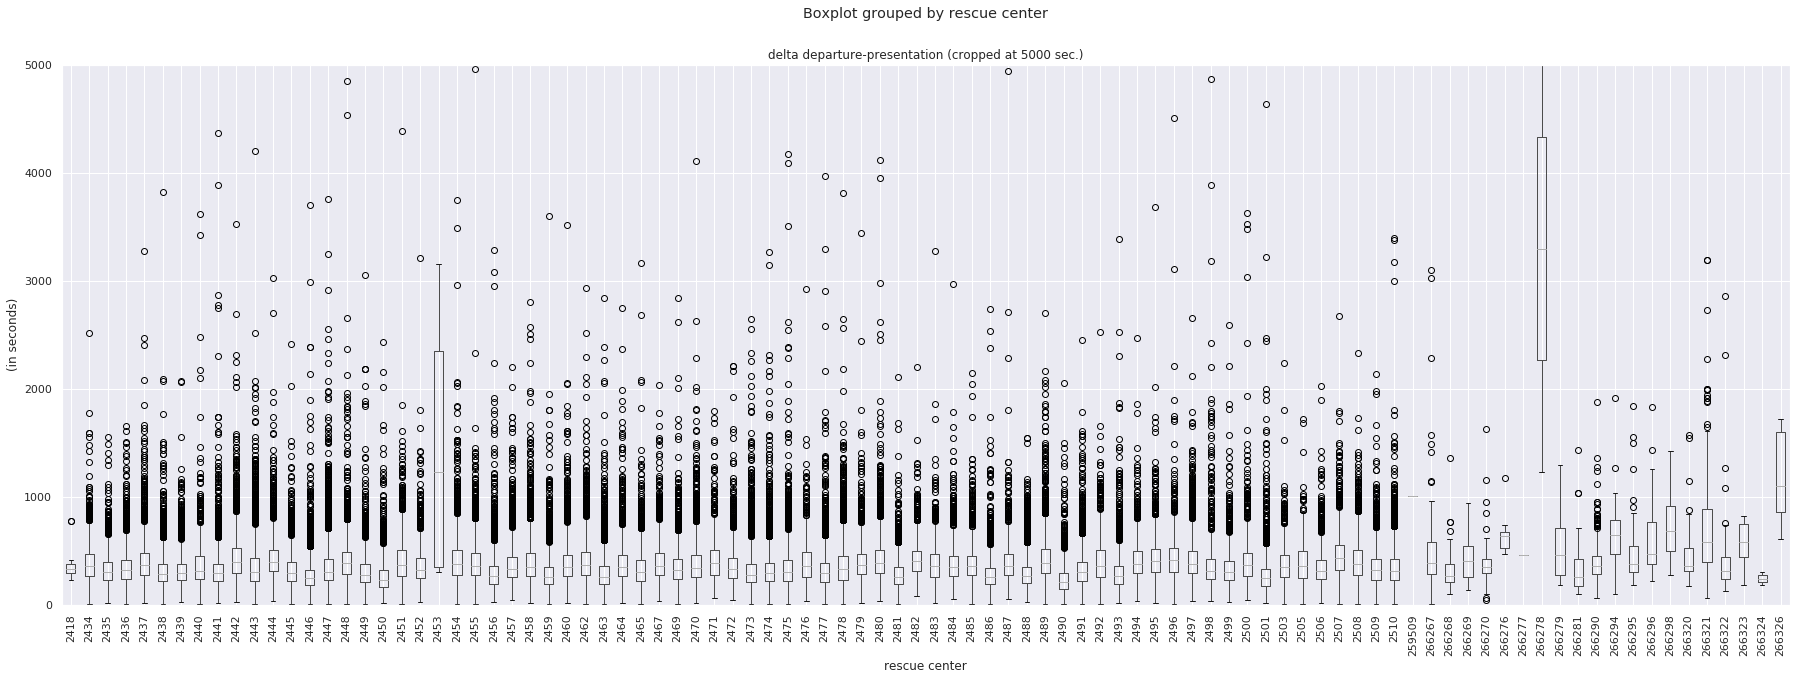

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

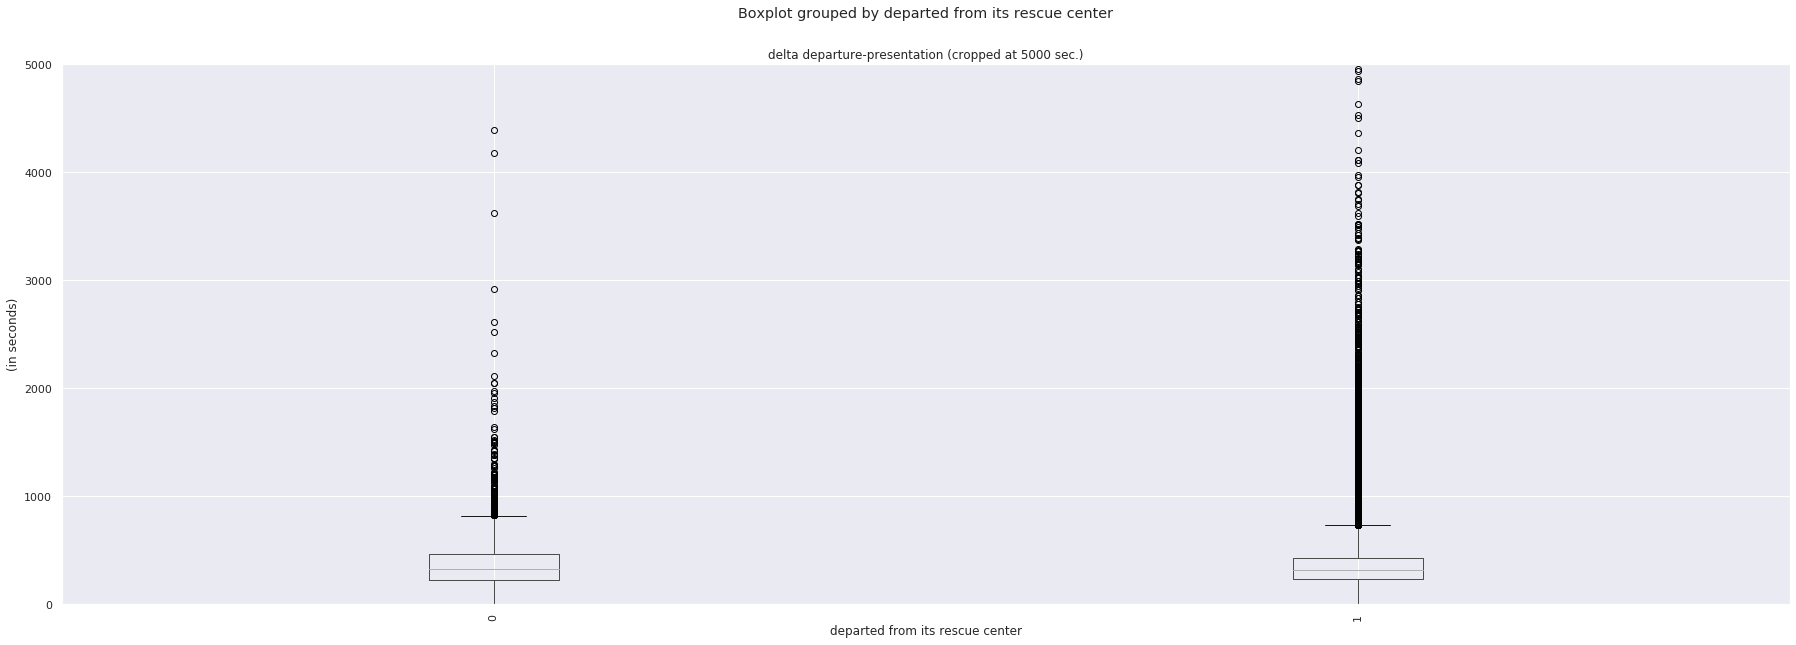

In [85]:
for var in categ_vars:
    boxplot(joined, "delta departure-presentation", var, upper_clip=5000, save_path="../report/figs/boxplots/")

<Figure size 2160x720 with 0 Axes>

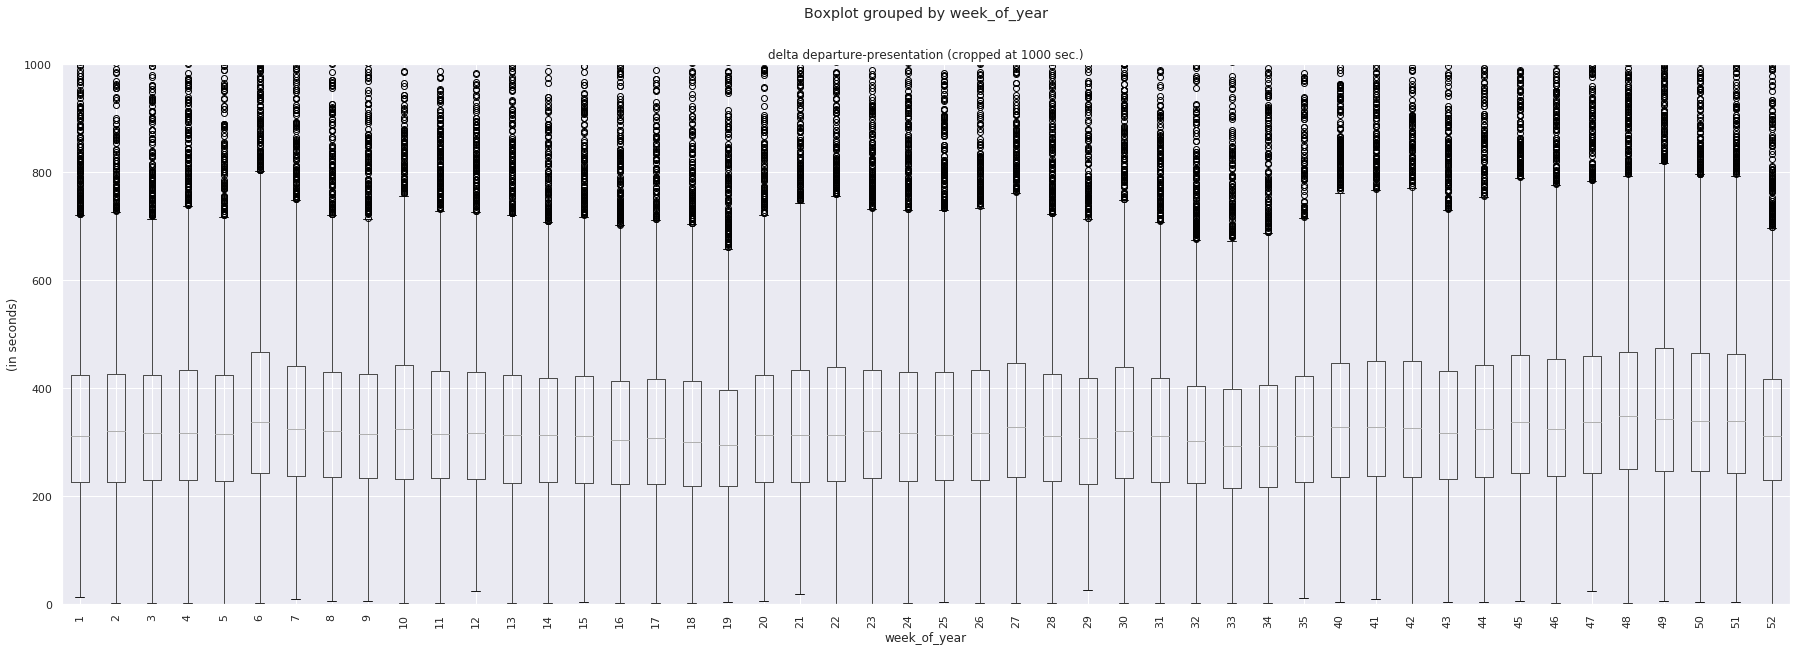

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

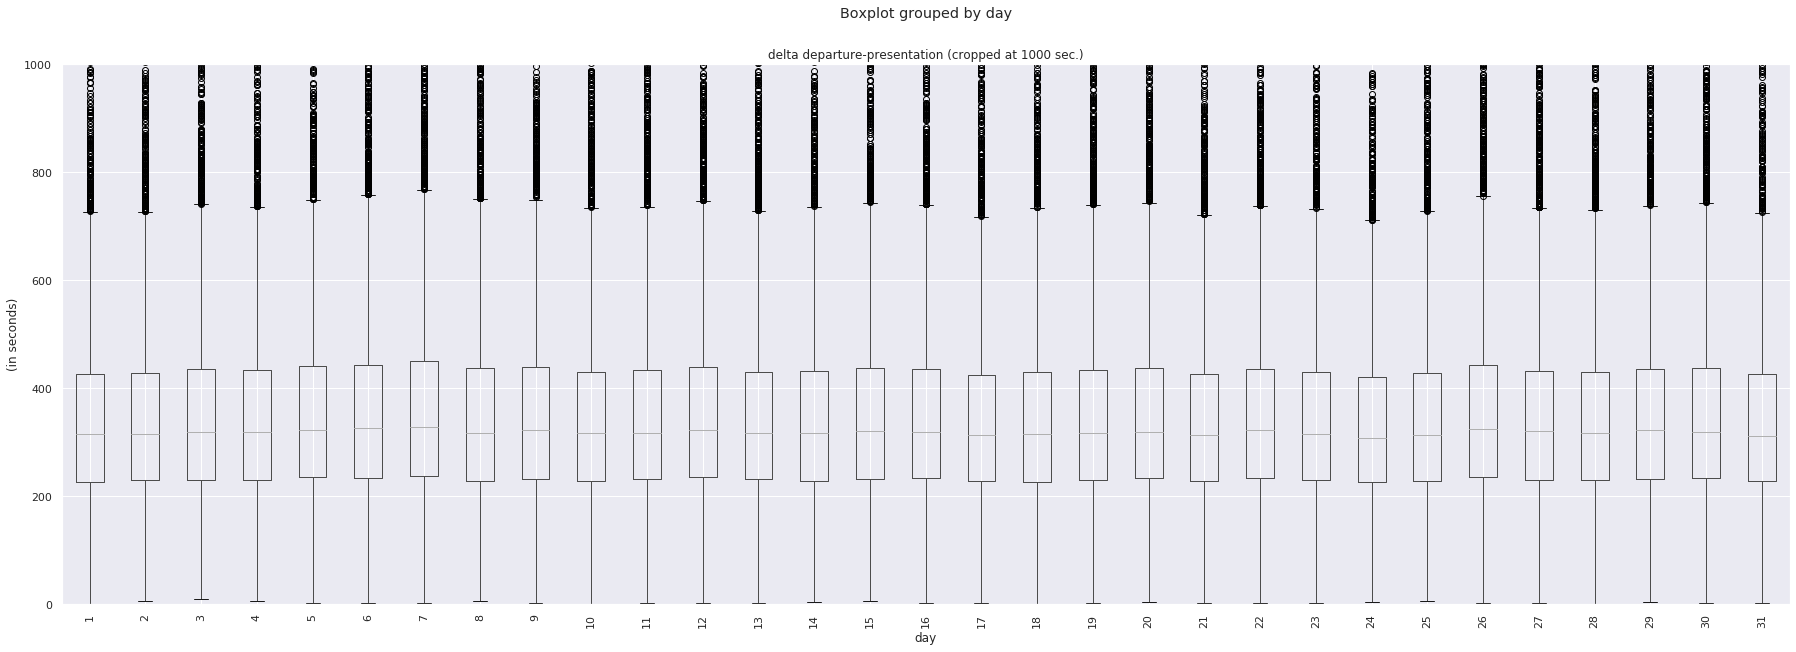

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

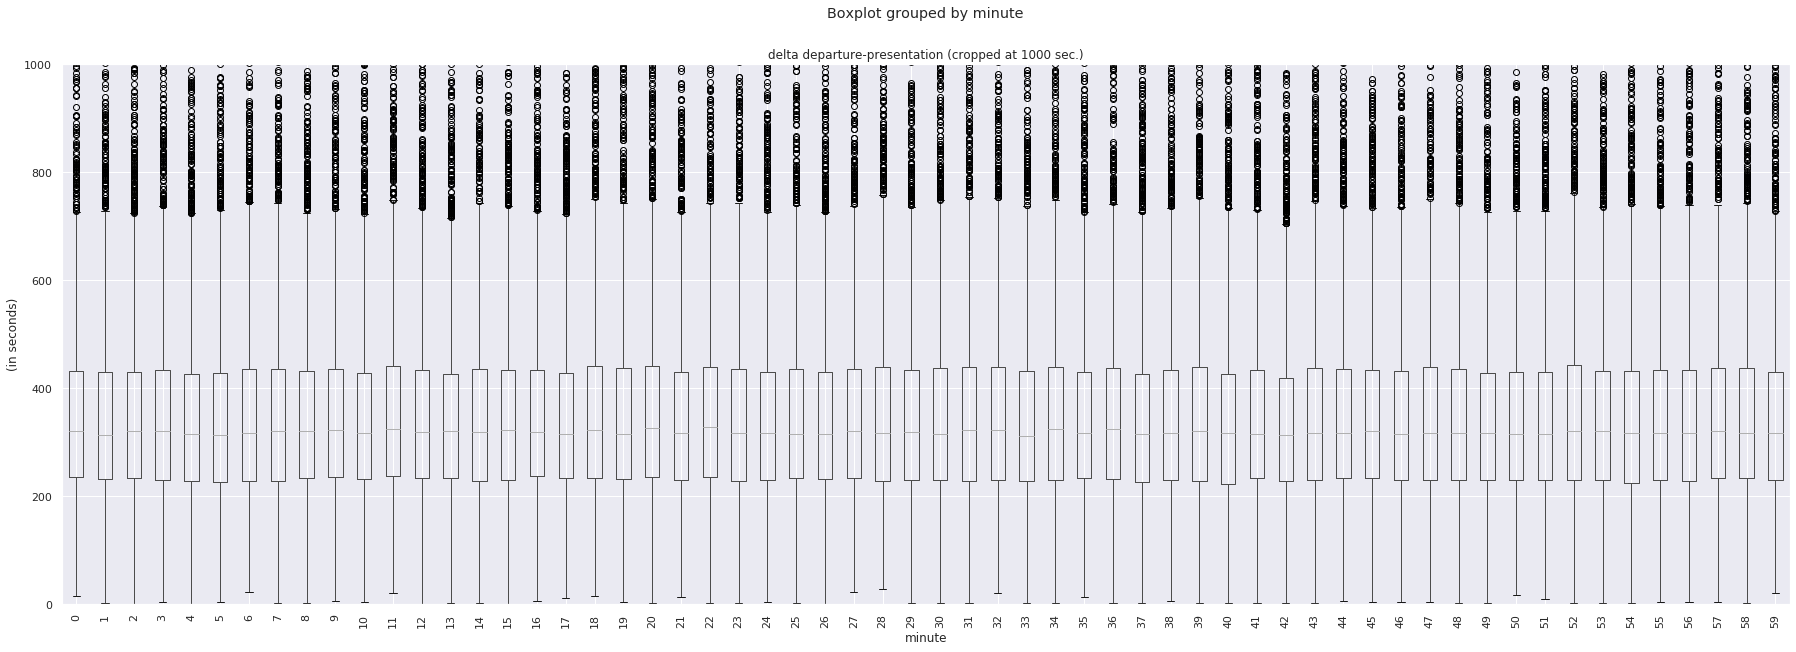

In [111]:
for var in time_vars:
    boxplot(joined, "delta departure-presentation", var, upper_clip=1000, save_path="../report/figs/boxplots/time")

Premières observations intéressantes : on a effectivement un grande variabilité selon ce paramètre. On peut donc benoitement faire une première soumission qui prédit comme durée la moyenne du temps mis par le véhicule

In [7]:
x_test = pd.read_csv('../data/test/x_test.csv', sep=',')

In [12]:
moy_vehicule = dict()
std_vehicule = dict()
nb_vehicule = dict()

for vehicule in especes:
    sous_base = data.loc[data["emergency vehicle type"] == vehicule]
    delta_spec = np.array(sous_base["delta selection-departure"])
    moy_vehicule[vehicule]=np.mean(delta_spec)
    std_vehicule[vehicule]=np.std(delta_spec)
    nb_vehicule[vehicule]=delta_spec.shape

In [9]:
n = len(x_test)
easy_pred = np.zeros(n)
constant_trajet = np.ones(n)
total = np.zeros(n)

for i in range(n):
    v = x_test["emergency vehicle type"][i]
    if v in moy_vehicule:
        easy_pred[i] = moy_vehicule[v]
    else:
        easy_pred[i] = t_mean
    
moy_intervention = y_train['delta departure-presentation'].mean()
print(moy_intervention)
constant_trajet *= moy_intervention

total = easy_pred + constant_trajet

356.16102618345286


In [10]:
# creation de la solution
submission = pd.concat([pd.DataFrame(x_test[['emergency vehicle selection']].values), \
           pd.DataFrame(easy_pred), \
           pd.DataFrame(constant_trajet), \
           pd.DataFrame(total)], \
           axis=1)


submission.columns = list(y_train.columns.values)

submission.set_index('emergency vehicle selection', inplace=True)

submission.to_csv('../soumissions/par_type_vehicule.csv', sep=",")

### score obtenu : Your submission score is : 0.013807632812333845

Cela étant, le nombre de données est parfois non significatif, avec un seul représentant par exemple. On essaie donc de regrouper les catégories proches, pour avoir des données plus robustes.

('UMH DEBREPED', 8.0) (1,)
('SP BALLON', 14.0) (1,)
('VIRB', 16.0) (1,)
('VELD', 29.0) (1,)
('VPC GFIS', 52.833333333333336) (6,)
('UMH 93', 56.1) (10,)
('VPC GIS', 70.77941176470588) (68,)
('UMH 92', 75.33333333333333) (6,)
('VE2I', 78.55357142857143) (56,)
('SPTT', 80.5) (2,)
('DAP', 88.0) (1,)
('UMH 94', 91.8) (5,)
('UMH LARIB', 93.5) (8,)
('CFS', 95.875) (8,)
('UMH BOBI', 96.5) (2,)
('OHFOM', 99.21686746987952) (83,)
('UMH 75', 99.72093023255815) (43,)
('UMH STDE', 102.0) (1,)
('UMH MONDOR', 107.66666666666667) (3,)
('CRF', 112.1059649122807) (1425,)
('SFCB', 112.46) (50,)
('FNPC', 115.22247972190034) (863,)
('FFSS', 115.36507936507937) (126,)
('UMPS', 120.65517241379311) (29,)
('UMH NECK', 126.26315789473684) (19,)
('VSAV BSPP', 132.63683122415736) (159620,)
('VSAV SDIS', 133.8) (5,)
('UMH NECKPED', 134.0) (2,)
('CRAC', 136.58157894736843) (380,)
('VRA', 136.64893617021278) (94,)
('FMOGP BSPP', 139.7826086956522) (23,)
('CA', 141.5) (14,)
('UMH PITIE', 141.88888888888889) (9,)
('U

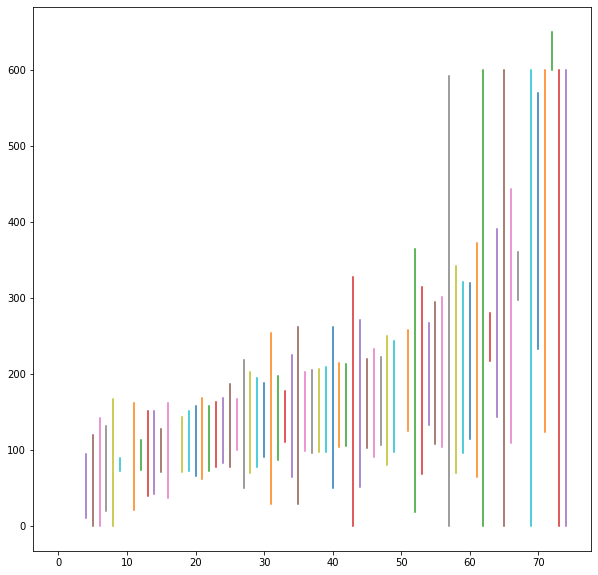

In [14]:
# affichage des valeurs moyennes
# tri du dictionnaire
import operator
sorted_mean = sorted(moy_vehicule.items(), key=operator.itemgetter(1))
plt.figure(figsize=(10,10))
i=0
for v in sorted_mean:
    plt.plot([i, i], [max(v[1]- std_vehicule[v[0]], 0), min(v[1]+ std_vehicule[v[0]], 600)])
    plt.xticks()
    print(v, nb_vehicule[v[0]])
    i+=1
    #if i>72:
    #    break
plt.show()

On voit qu'on a une bonne régularité, avec juste deux trois modèles qui peuvent être problématique. On peut essayer, pour mettre cette feature avec d'autre, d'associer un entier correspondant à ce rang

## Dépendance avec la cause de l'appel

On fait le même travail pour la cause de l'appel, on commence par regarder la répartition.

In [15]:
from collections import Counter
#print(x_train["alert reason"])
c = Counter(x_train["alert reason"])
c.most_common(10)

[(2162, 68515),
 (2112, 37332),
 (2113, 23112),
 (2163, 15272),
 (1922, 13339),
 (2135, 7559),
 (2124, 5927),
 (2711, 5919),
 (2134, 3413),
 (2120, 3392)]

On regarde les temps moyens pour chacune de ces causes et on fait de même avec alert reason category

2724
2720
2311
2411
93529
2430
2414
1944
2210
1917
2127
2726
2727
10971
2218


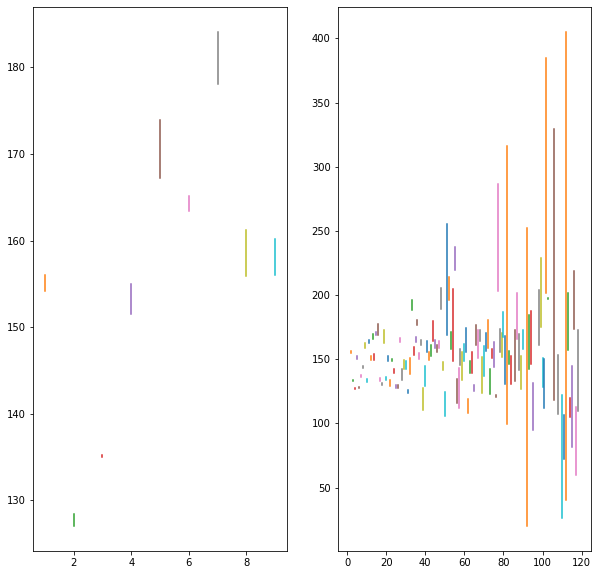

In [70]:
Y = []
std_cat = []
Z = dict()
std_Z = dict()

for i in range(10):
    sous_base = data.loc[data["alert reason category"] == i]
    Y.append(sous_base["delta selection-departure"].mean())
    std_cat.append(sous_base["delta selection-departure"].sem())
    
for category in list(c):
    sous_base = data.loc[data["alert reason"] == category]
    Z[category]=sous_base["delta selection-departure"].mean()
    if sous_base["delta selection-departure"].mean() > 200:
        print(category)
    std_Z[category] = sous_base["delta selection-departure"].sem()

plt.figure(figsize=(10,10))

plt.subplot(1,2,1)    
    
for i in range(10):
    plt.plot([i, i], [Y[i]- std_cat[i], Y[i]+ std_cat[i]])
    
plt.subplot(1,2,2)
j = 0
for i in Z:
    if Z[i] >400:
        continue
    j+=1
    plt.plot([j, j], [Z[i]- std_Z[i], Z[i]+ std_Z[i]])



plt.show()

On créé un fichier qui pour chaque intervention précise cinq facteurs :
- le temps moyen pour le vehicule considéré
- la variance pour ce temps moyen
- le temps moyen pour la raison considérée
- sa variance
- le nombre d'intervention sur l'incident

In [17]:
n = len(x_train)
print(n)

temps_veh = np.zeros(n)
var_veh = np.zeros(n)
temps_reason = np.zeros(n)
var_reason = np.zeros(n)
temps_cat = np.zeros(n)
var_cat = np.zeros(n)

for i in range(n):
    v = data["emergency vehicle type"][i]
    temps_veh[i] = moy_vehicule[v]
    var_veh[i] = 1/ (std_vehicule[v]+1e-8)
    cat = data["alert reason category"][i]
    temps_cat[i] = Y[cat]
    var_cat[i] = 1/ (std_cat[cat]+1e-8)
    reason = data["alert reason"][i]
    temps_reason[i] = Z[reason]
    var_reason[i] =1/ (std_Z[reason]+1e-8)
    
print(temps_veh)

219337
[132.63683122 151.69502232 132.63683122 ... 132.63683122 132.63683122
 165.04235946]


In [63]:
nb_veh_per_inter = data[['emergency vehicle selection', 'intervention']].groupby(['intervention']).count()
nb_veh_per_inter = nb_veh_per_inter.rename(columns={'emergency vehicle selection': 'nb_vehicles'})

In [64]:
nb_veh_per_inter

nb_vehicles
intervention             
12649492                1
12650159                1
12651734                1
12651765                1
12651790                1
...                   ...
13822484                1
13822495                1
13822549                1
13822553                1
13822594                1

[200894 rows x 1 columns]

In [65]:
df_joined = data.join(nb_veh_per_inter, on="intervention", how="left")

In [67]:
df_joined[df_joined['nb_vehicles'] != 1]

emergency vehicle selection  intervention  alert reason category  \
23                          5308467      13591252                      3   
24                          4796721      12779535                      6   
27                          4751527      12711099                      1   
29                          4993090      13085609                      6   
32                          5328689      13622052                      1   
...                             ...           ...                    ...   
219277                      5071294      13212620                      1   
219296                      4736959      12688607                      1   
219309                      4921153      12974526                      3   
219314                      4946237      13015660                      1   
219322                      5017122      13124995                      3   

        alert reason  intervention on public roads  floor  \
23              2113                             0      0   
24              2426                             0      1   
27              1929                             0     -1   
29              2421                             0      3   
32              1922                             0      1   
...              ...                           ...    ...   
219277          1922                             0     -1   
219296          1922                             0      0   
219309          2135                             0      6   
219314          1922                             0      4   
219322          2113                             0      0   

        location of the event  longitude intervention  latitude intervention  \
23                        NaN                2.309547              48.877509   
24                      139.0                2.488039              48.803080   
27                      257.0                2.476590              48.897812   
29                      100.0                2.508915              48.866068   
32                      104.0                2.547698              48.847943   
...                       ...                     ...                    ...   
219277                  103.0                2.261429              48.838717   
219296                  135.0                2.365960              48.943440   
219309                  139.0                2.329509              48.879171   
219314                  137.0                2.335409              48.905138   
219322                  148.0                2.324105              48.855304   

        emergency vehicle  ...  \
23                   3083  ...   
24                   5814  ...   
27                   5761  ...   
29                   2298  ...   
32                   5712  ...   
...                   ...  ...   
219277               5807  ...   
219296               4903  ...   
219309               1985  ...   
219314               5819  ...   
219322               4502  ...   

       delta position gps previous departure-departure  \
23                                                 NaN   
24                                                 NaN   
27                                                 NaN   
29                                                 NaN   
32                                                 NaN   
...                                                ...   
219277                                             NaN   
219296                                             NaN   
219309                                             NaN   
219314                                             NaN   
219322                                             NaN   

                        GPS tracks departure-presentation  \
23                                                    NaN   
24      2.502333,48.798054;2.494278,48.801388;2.489444...   
27      2.490222,48.904888;2.490222,48.904945;2.488333...   
29                                                 

In [68]:
df_joined.keys()

Index(['emergency vehicle selection', 'intervention', 'alert reason category',
       'alert reason', 'intervention on public roads', 'floor',
       'location of the event', 'longitude intervention',
       'latitude intervention', 'emergency vehicle', 'emergency vehicle type',
       'rescue center', 'selection time', 'date key sélection',
       'time key sélection', 'status preceding selection',
       'delta status preceding selection-selection',
       'departed from its rescue center', 'longitude before departure',
       'latitude before departure',
       'delta position gps previous departure-departure',
       'GPS tracks departure-presentation',
       'GPS tracks datetime departure-presentation', 'OSRM response',
       'OSRM estimated distance', 'OSRM estimated duration',
       'delta selection-departure', 'delta departure-presentation',
       'delta selection-presentation', 'nb_vehicles'],
      dtype='object')

In [18]:
# creation des data utilisées
simple = pd.concat([pd.DataFrame(x_train[['emergency vehicle selection']].values), \
           pd.DataFrame(temps_veh), \
           pd.DataFrame(var_veh), \
           pd.DataFrame(temps_reason), \
           pd.DataFrame(var_reason), \
           pd.DataFrame(temps_cat), \
           pd.DataFrame(var_cat)], \
           axis=1)
simple.columns = ['emergency vehicle selection', 'temps vehicule', 'variance vehicule', 'temps reason', 'variance reason', 'temps cat', 'variance category']

simple.set_index('emergency vehicle selection', inplace=True)

simple.to_csv('../data/simple.csv', sep=",")

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression


In [20]:
#simple = simple.fillna(value=0)
print(len(x_train))
print(len(x_train[['emergency vehicle selection']].values))
last_chance = pd.concat([pd.DataFrame(x_train[['emergency vehicle selection']].values), \
           pd.DataFrame(temps_veh), \
           pd.DataFrame(temps_reason), \
           pd.DataFrame(temps_cat)], \
           axis=1)
print(last_chance)
clf = LinearRegression()
clf.fit(last_chance, y_train['delta selection-departure'])

clf.coef_

219337
219337
              0           0           0           0
0       5105452  132.636831  138.481515  135.152409
1       4720915  151.695022  155.876666  135.152409
2       5365374  132.636831  133.571045  135.152409
3       4741586  132.636831  138.481515  135.152409
4       5381209  132.636831  138.481515  135.152409
...         ...         ...         ...         ...
219332  4864471  132.636831  133.571045  135.152409
219333  5357433  132.636831  138.481515  135.152409
219334  4907336  132.636831  143.987618  135.152409
219335  4784220  132.636831  138.481515  135.152409
219336  4868867  165.042359  159.876404  164.301413

[219337 rows x 4 columns]


array([ 5.96985465e-06,  8.42185092e-01,  6.07033642e-01, -2.49458079e-01])

183.5497217684122
17758


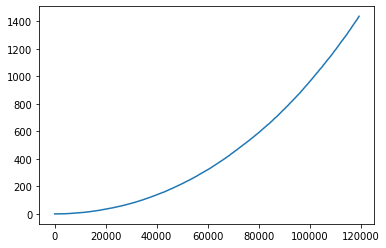

In [54]:
from sklearn.metrics import r2_score
r2_score(clf.predict(last_chance), y_train['delta selection-departure'])

print(np.max(clf.predict(last_chance)))
print(np.max(y_train['delta selection-departure']))
plt.plot(sorted((clf.predict(last_chance) - y_train['delta selection-departure'])**2)[:-100000])

In [28]:
last_chance = pd.concat([pd.DataFrame(x_train[['emergency vehicle selection']].values), \
           pd.DataFrame(temps_veh), \
           pd.DataFrame(temps_reason), \
           pd.DataFrame(temps_cat)], \
           axis=1)

clf = LinearRegression()
clf.fit(last_chance, y_train['delta departure-presentation'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [29]:
from sklearn.metrics import r2_score
r2_score(clf.predict(last_chance), y_train['delta selection-departure'])

-42.79184514669953